# Producing the main figure for the paper

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from kinematics_and_rotation.dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Gaia-McQuillan crossmatch and make cuts.

In [3]:
gaia_mc0 = pd.read_csv("gaia_mc2.csv")
print(np.shape(gaia_mc0))

# Cut out visual binaries.
gaia_mc1 = gaia_mc0.iloc[gaia_mc0.flag.values == 1]
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3500, 5500
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
# bmax = 20
bmax = 15
bmin = 10
m &= (gaia_mc1.b.values < bmax) * (bmin < gaia_mc1.b.values)
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

gaia_mc = gaia_mc1.iloc[m]

# # Restrict to stars with Vz
# m &= np.isfinite(gaia_mc1.vz.values)
# print(np.shape(gaia_mc1.iloc[m]), "only stars with Vz")

# Remove velocity outliers
v_clipped, clipping_mask = sigma_clip(gaia_mc.vb.values, 3)
gaia_mc = gaia_mc.iloc[clipping_mask]

(31357, 133)
(11700, 133) no visual binaries or subgiants
(11436, 133) no large vb uncertainties
(11272, 133) no faint stars
(10586, 133) no rapid rotators
(10454, 133) no hot or cold stars
(4635, 133) no high latitude stars
niter =  5 78 stars removed kurtosis =  0.1517543870275544


Make cuts in log age.

In [4]:
age_bins = 10**np.linspace(np.log10(.5), np.log10(4.5), 7)

# age_bins = 10**np.linspace(np.log10(.5), np.log10(4.5), 5)
# age_bins = 10**np.linspace(np.log10(.5), np.log10(6.), 5)

# age_bins = 10**np.linspace(np.log10(.5), np.log10(3.5), 7)
mid_age_bins = age_bins[:-1] + .5*np.diff(age_bins)
age_masks = select_stars(gaia_mc, age_bins, "age")

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


Set up color values.

In [5]:
cmap = plt.cm.get_cmap('viridis_r')
vmin, vmax = np.log10(1e9*min(mid_age_bins)), np.log10(1e9*max(mid_age_bins))
log_agebins = np.log10(age_bins*1e9)
age_midbin = np.diff(log_agebins)*.5 + log_agebins[:-1]
color_values = (age_midbin - vmin)/(vmax - vmin)
rgba = cmap(color_values)

Format data.

In [6]:
x = gaia_mc.color_teffs.values
y = gaia_mc.Prot.values
v = gaia_mc.vb.values
# v = gaia_mc.v_ra.values
# v = gaia_mc.v_dec.values
verr = gaia_mc.vb_err.values
xerr = np.ones_like(x)*100
xlim = (maxt + 100, mint - 200)

tbins = np.linspace(min(x), max(x), 10)
# tbins = np.linspace(min(x), max(x), 7)
# tbins = np.linspace(min(x), max(x), 6)
ds, derrs = [np.zeros((len(age_bins), len(tbins[:-1]))) for i in range(2)]

In [7]:
print(tbins)

[3501.71336315 3723.34219794 3944.97103274 4166.59986753 4388.22870232
 4609.85753712 4831.48637191 5053.1152067  5274.74404149 5496.37287629]


In [8]:
def betterstep_scatter(bins, y, c, label, **kwargs):
    new_x = [a for row in zip(bins[:-1], bins[1:]) for a in row]
    new_y = [a for row in zip(y, y) for a in row]
    ax = kwargs.pop("ax", plt.gca())
    ax.plot(new_x, new_y, color=c, lw=2, rasterized=True, label=label)

Make main figure

  0%|          | 0/1000 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [00:01<00:00, 680.90it/s]


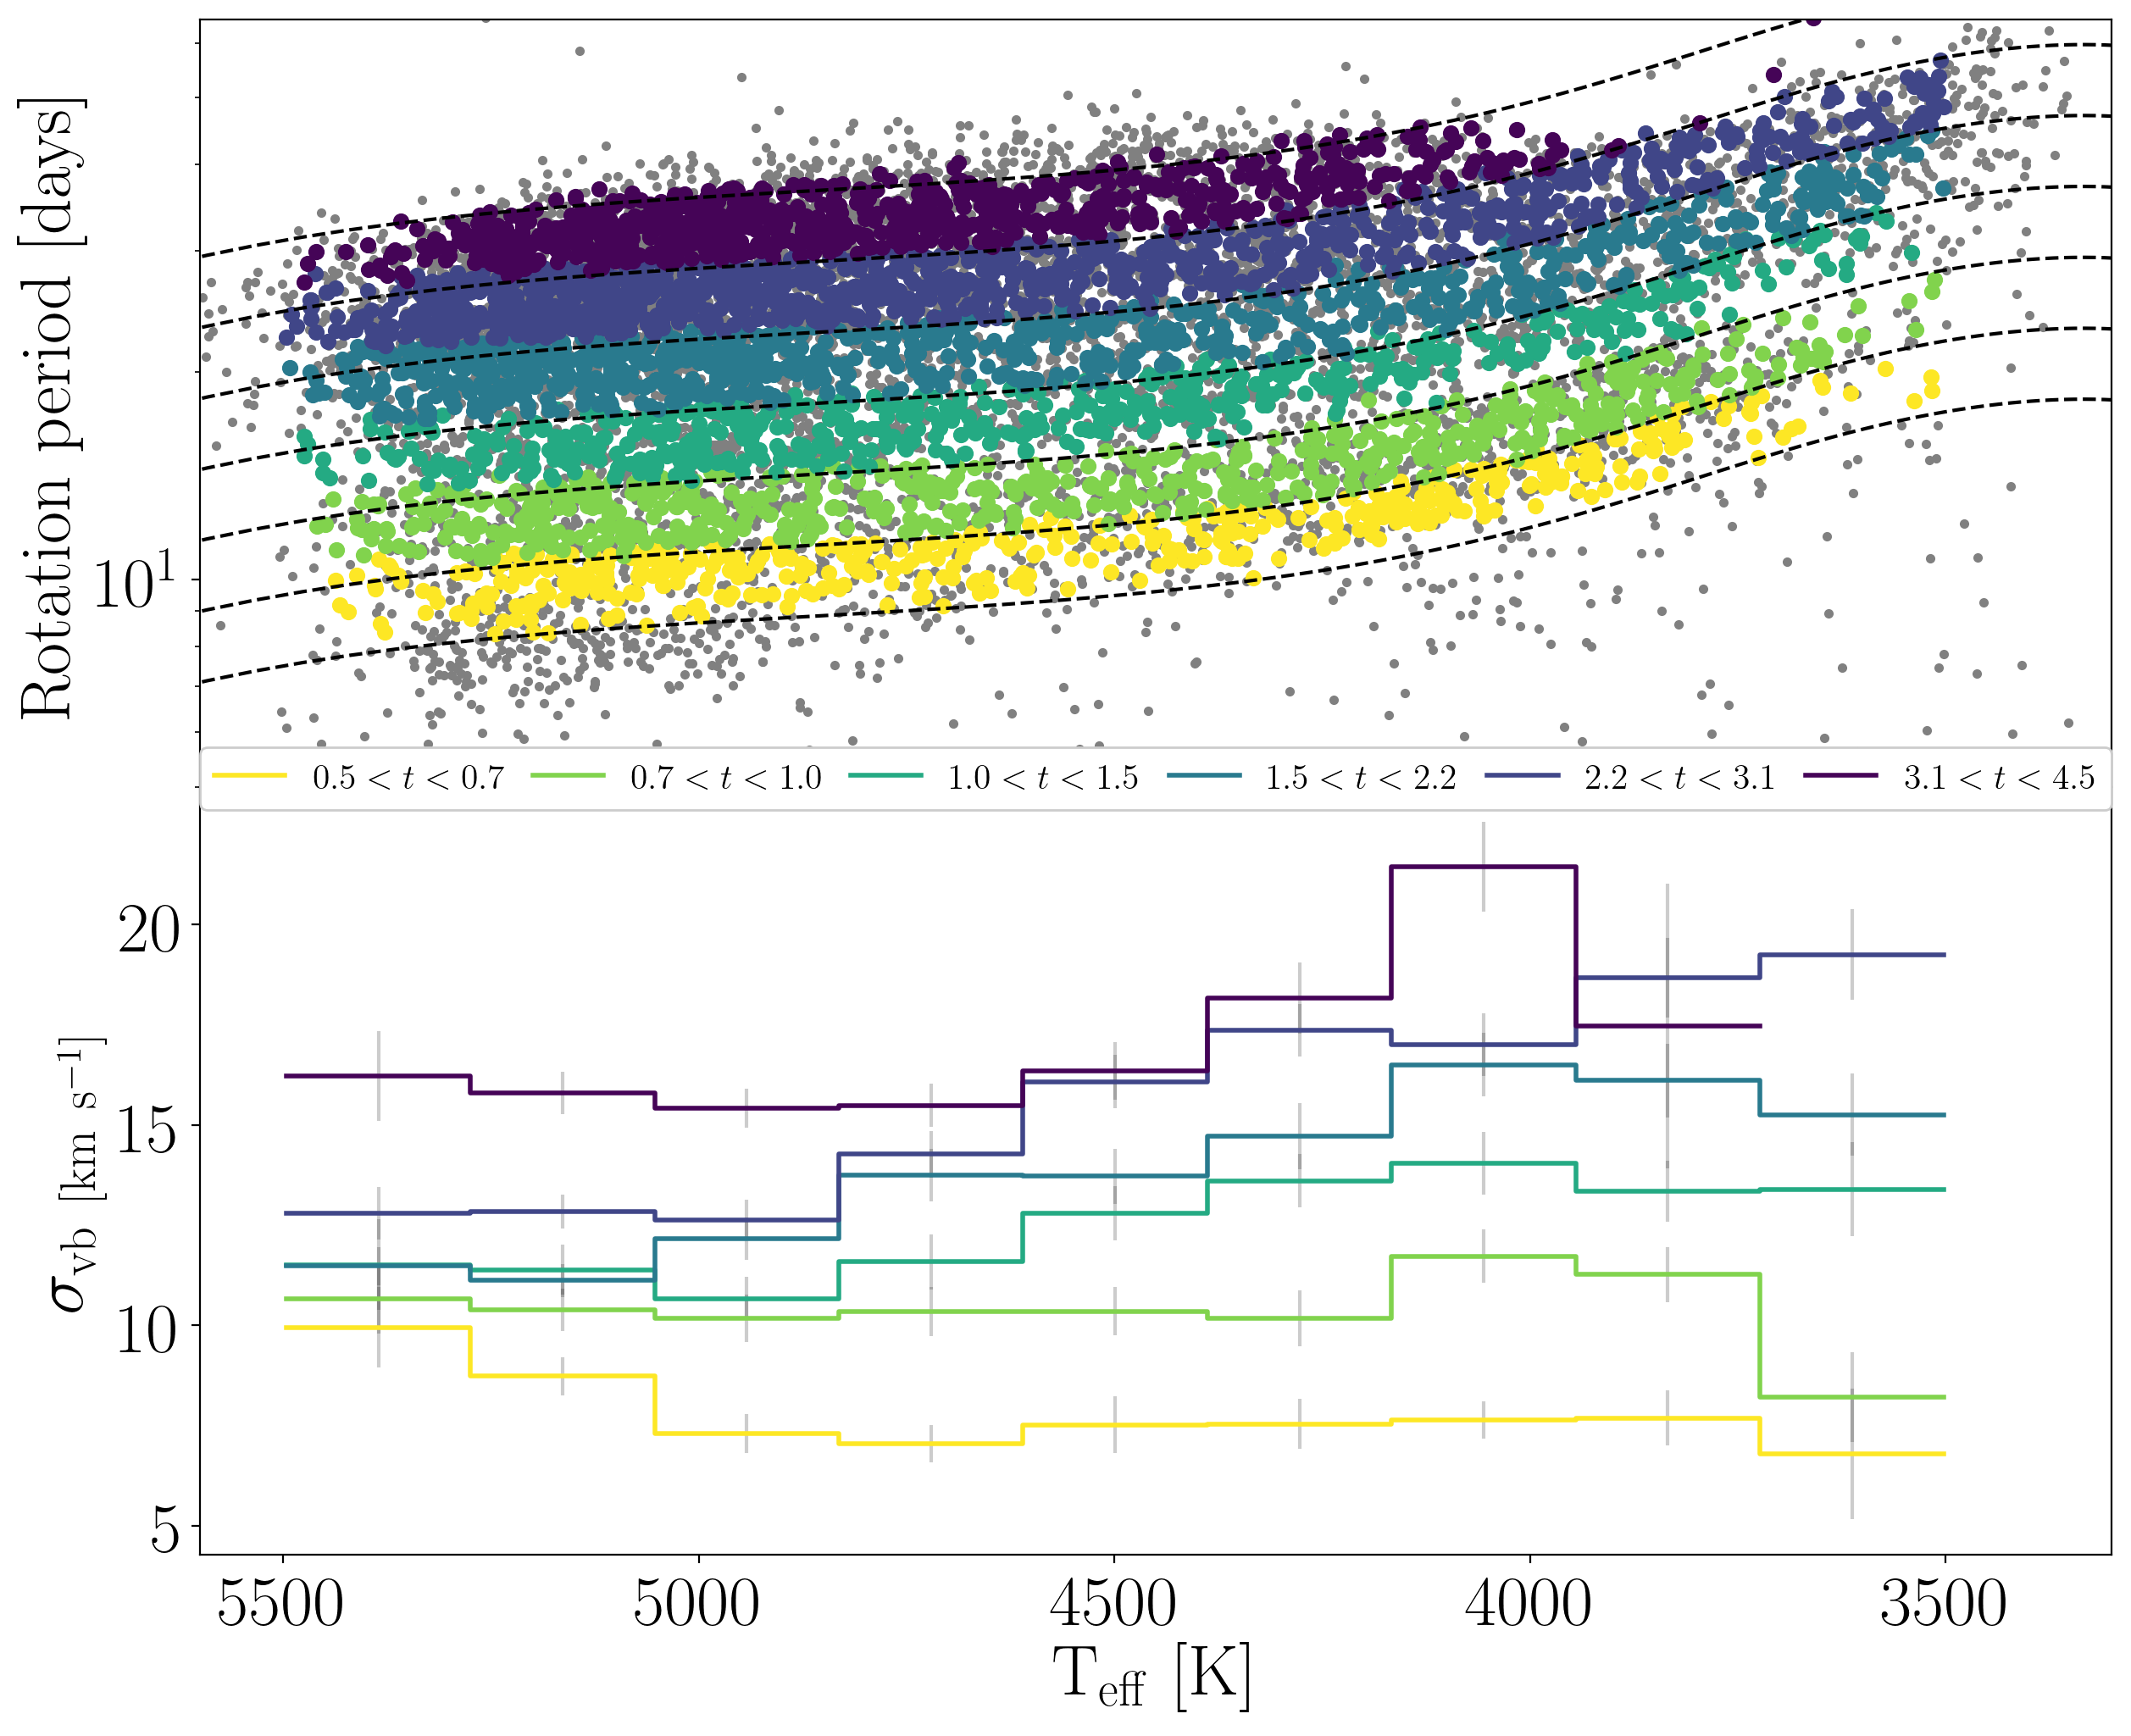

In [12]:
plt.rcParams.update({'legend.fontsize': 15})

from stardate.lhf import gk_rotation_model
from kinematics_and_rotation.photometric_teff import bprp_to_teff

fig = plt.figure(figsize=(16, 12), dpi=200)

ax1 = fig.add_subplot(211)

# Background scatter.
ax1.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".5", rasterized=True, zorder=0)

# Plot lines
xs_bprp = np.linspace(.8, 2.8, 100)
xs_teff = bprp_to_teff(xs_bprp)
log10_ages = np.log10(age_bins*1e9)

# Top panel: period-teff relations
for i, m in enumerate(age_masks):
#     v_clipped, clipping_mask = sigma_clip(v[m], 3)
#     cb1 = ax1.scatter(x[m][clipping_mask], y[m][clipping_mask], c=rgba[i],
#                       vmin=vmin, vmax=vmax, rasterized=True, zorder=1, s=35,
#                       label="${0:.1f} < t < {1:.1f}$".format(age_bins[i], age_bins[i+1]))
    
    cb1 = ax1.scatter(x[m], y[m], c=rgba[i], vmin=vmin, vmax=vmax, rasterized=True, zorder=1, s=35,
                      label="${0:.1f} < t < {1:.1f}$".format(age_bins[i], age_bins[i+1]))
    
    prots = 10**gk_rotation_model(log10_ages[i], xs_bprp)
    plt.plot(xs_teff, prots, "k--")
prots = 10**gk_rotation_model(log10_ages[-1], xs_bprp)
plt.plot(xs_teff, prots, "k--")

    
# Add the sun
ax1.scatter(5778, 26, facecolors='w', edgecolors="k", s=200, zorder=3, rasterized=True)
ax1.plot(5778, 26, "k.", zorder=3, rasterized=True)
    
ax1.set_ylim(5, 65)
ax1.set_ylabel("$\mathrm{Rotation~period~[days]}$")
ax1.set_yscale("log")
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(212, sharex=ax1)

# Bottom panel: velocity dispersion-teff relations
for i, m in enumerate(age_masks):
#     v_clipped, clipping_mask = sigma_clip(v[m], 3)
#     d, derr, k, kerr = MC_dispersion(x[m][clipping_mask], v_clipped, xerr[m][clipping_mask], 
#                                      verr[m][clipping_mask],
#                                      tbins, 1000, method="std")
    d, derr, k, kerr = MC_dispersion(x[m], v[m], xerr[m], verr[m],
                                     tbins, 1000, method="std")
    derrs[i, :] = err_on_sample_std_dev(d, len(x[m]))
    ds[i, :] = d
#     derrs[i, :] = err_on_sample_std_dev(d, len(x[m][clipping_mask]))
#     derrs[i, :] = derr
    midbin = np.diff(tbins)*.5+tbins[:-1]
    cb2 = betterstep_scatter(tbins, d, rgba[i],
                             label="${0:.1f} < t < {1:.1f}$".format(age_bins[i], age_bins[i+1]))
    ax2.errorbar(midbin, d, yerr=derr, fmt=".", zorder=0, ms=.01, color="k", alpha=.2,
                 rasterized=True)
    
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\sigma_\mathrm{vb~[km~s^{-1}]}$")
ax2.set_xlim(xlim)
plt.legend(bbox_to_anchor=(0., .97, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)

plt.subplots_adjust(hspace=0, right=0.83)
# plt.savefig("paper/age_cut.pdf")

Now make cuts in rotation period.

In [13]:
period_bins = 10**np.linspace(np.log10(7), np.log10(50), 9)
# period_bins = 10**np.linspace(np.log10(7), np.log10(50), 5)
mid_period_bins = period_bins[:-1] + .5*np.diff(period_bins)
period_masks = select_stars(gaia_mc, period_bins, "Prot")

pds, pderrs = [np.zeros((len(mid_period_bins), len(tbins[:-1]))) for i in range(2)]

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


Set the color scale.

In [14]:
cmap = plt.cm.get_cmap('viridis_r')
vmin, vmax = min(mid_period_bins), max(mid_period_bins)
color_values = (mid_period_bins - vmin)/(vmax - vmin)
rgba = cmap(color_values)

Format the data.

In [15]:
y = gaia_mc.Prot.values

  0%|          | 0/1000 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [00:01<00:00, 759.39it/s]


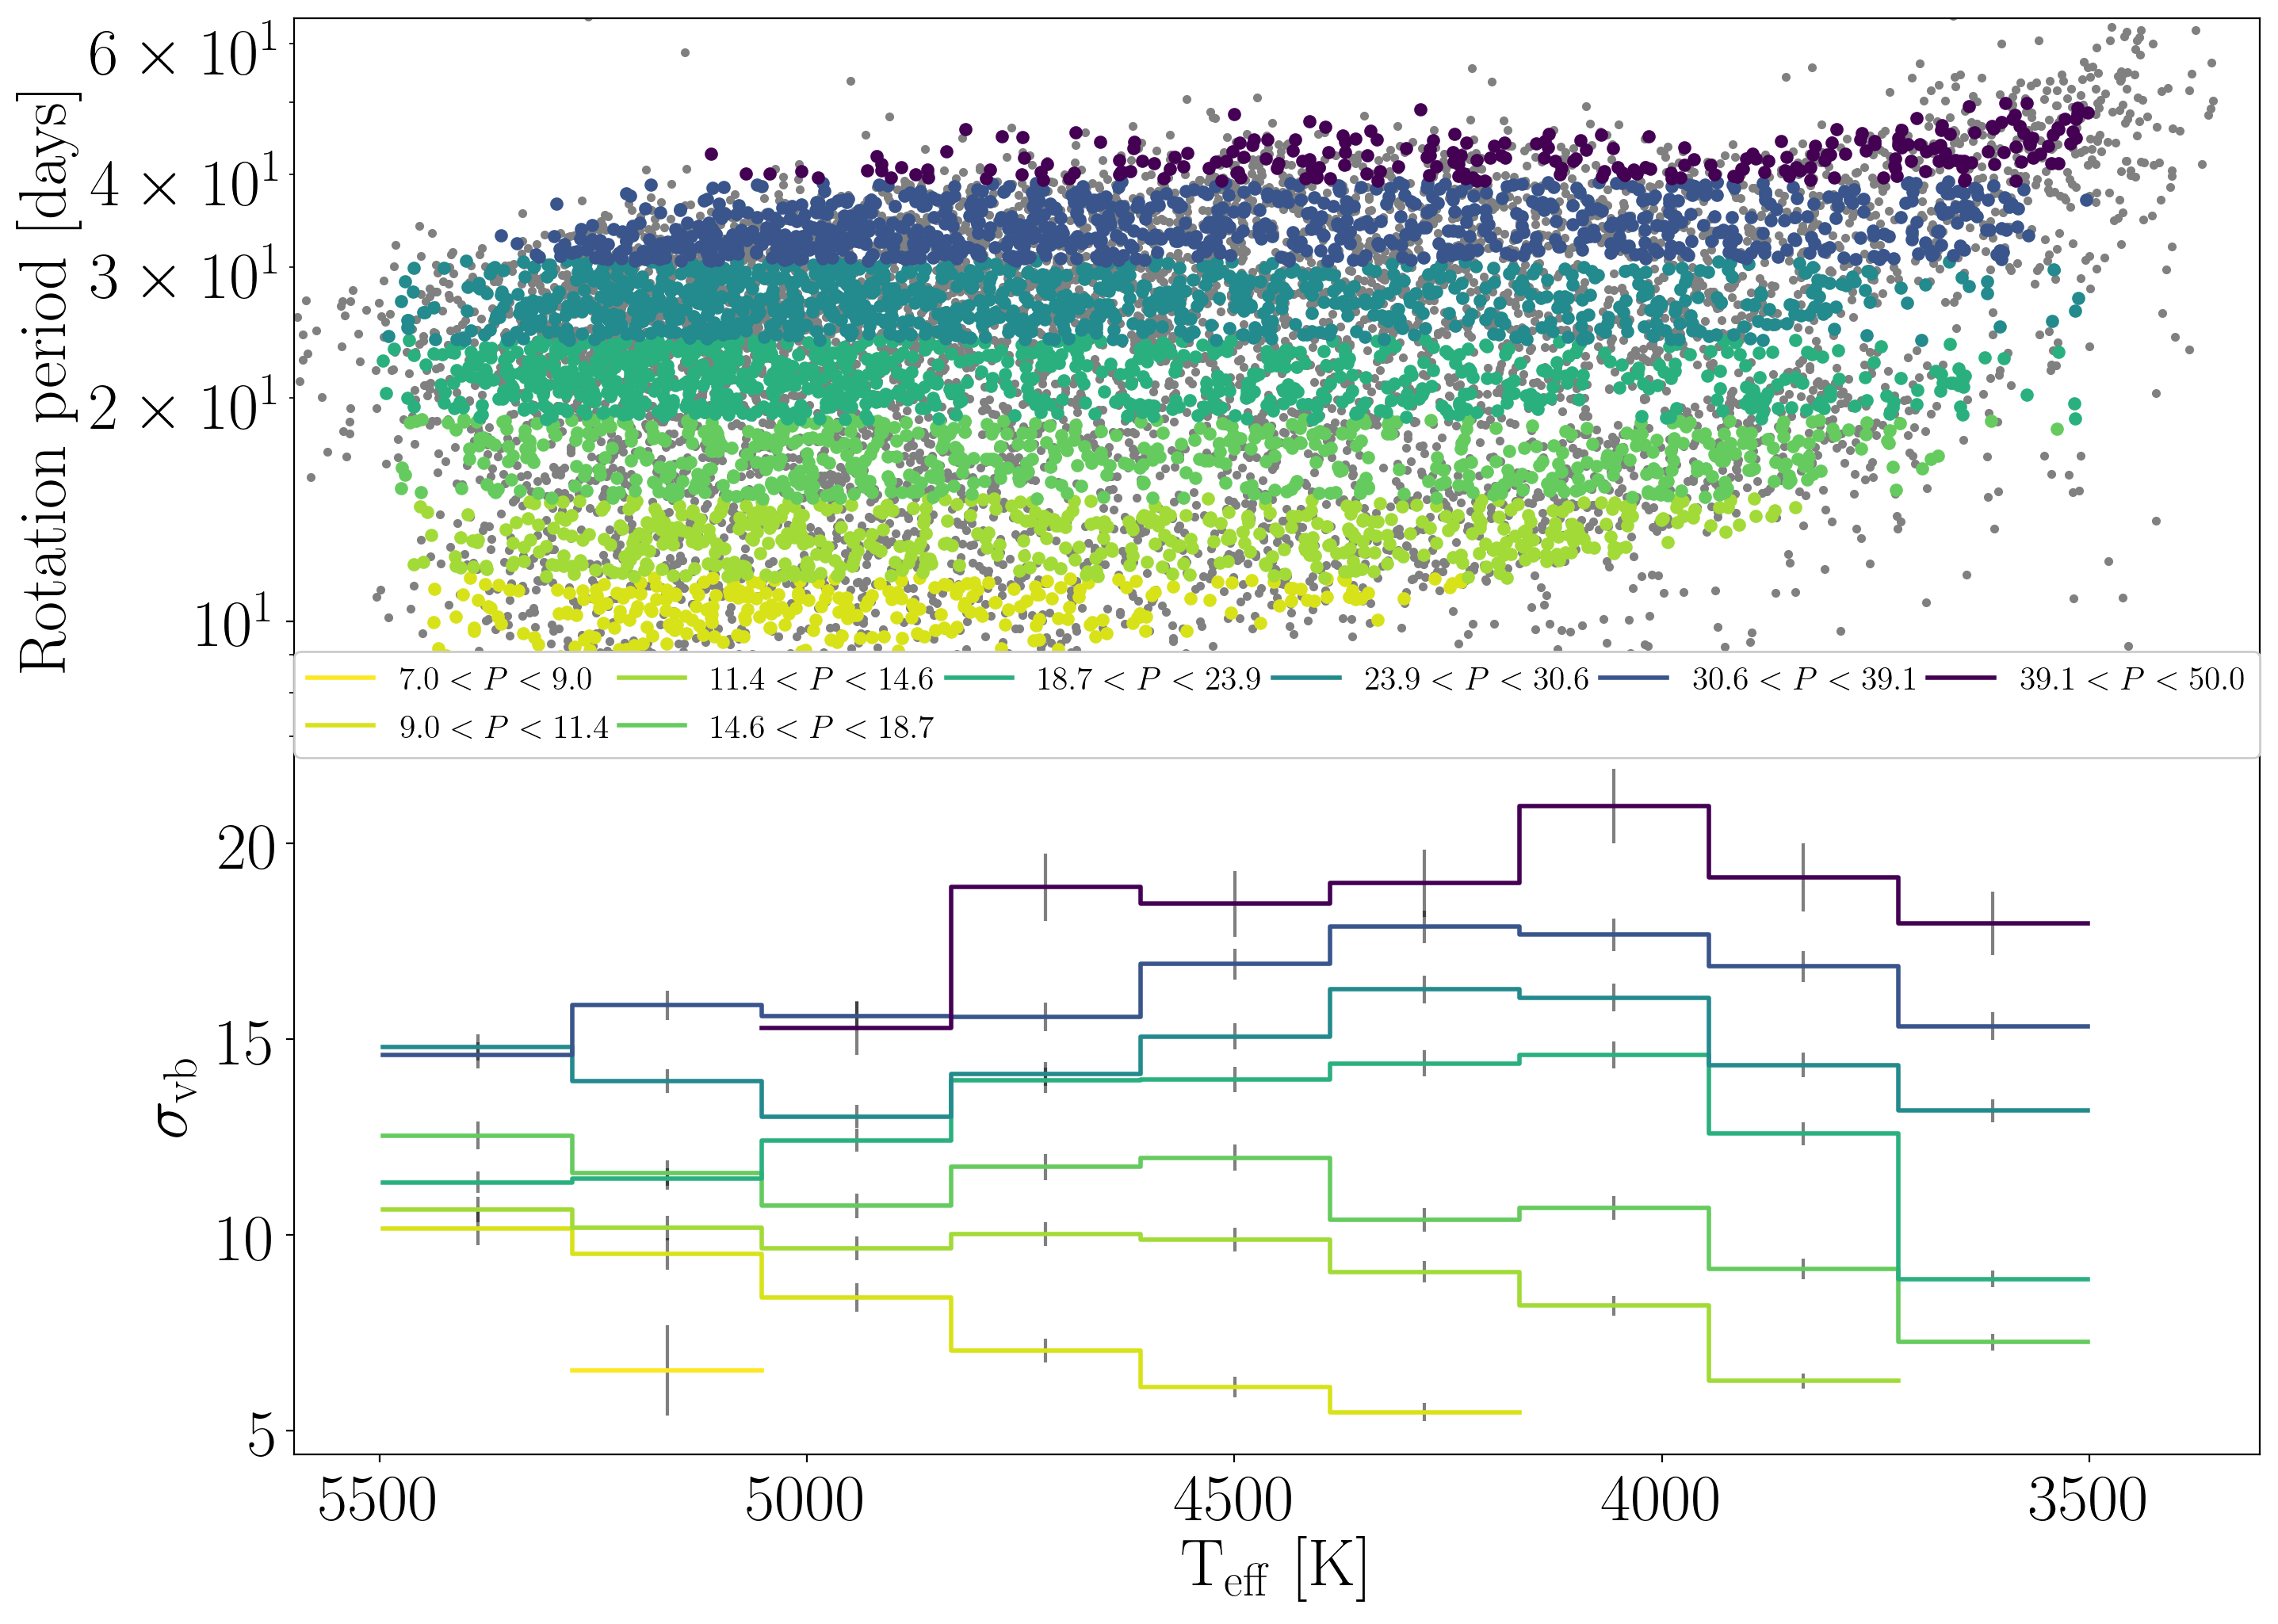

In [16]:
fig = plt.figure(figsize=(16, 12), dpi=200)

ax1 = fig.add_subplot(211)

# Background scatter
ax1.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".5", rasterized=True, zorder=0)

# Colored sections in period-color space
for i, m in enumerate(period_masks):
#     v_clipped, clipping_mask = sigma_clip(v[m], 3)
#     cb1 = ax1.scatter(x[m][clipping_mask], y[m][clipping_mask], c=rgba[i],
#                       vmin=vmin, vmax=vmax, rasterized=True, zorder=1, s=25,
#                       label="${0:.1f} < P < {1:.1f}$".format(period_bins[i], period_bins[i+1]))
    cb1 = ax1.scatter(x[m], y[m], c=rgba[i], vmin=vmin, vmax=vmax,
                      rasterized=True, zorder=1, s=25,
                      label="${0:.1f} < P < {1:.1f}$".format(period_bins[i], period_bins[i+1]))
    
# Sun
ax1.scatter(5778, 26, facecolors='w', edgecolors="k", s=200, zorder=3, rasterized=True)
ax1.plot(5778, 26, "k.", zorder=3, rasterized=True)
    
ax1.set_ylim(7, 65)
ax1.set_ylabel("$\mathrm{Rotation~period~[days]}$")
ax1.set_yscale("log")
plt.setp(ax1.get_xticklabels(), visible=False)

# Velocity-teff plot
ax2 = fig.add_subplot(212, sharex=ax1)

# Bottom panel: velocity dispersion-teff relations
for i, m in enumerate(period_masks):
#     v_clipped, clipping_mask = sigma_clip(v[m], 3)
#     d, derr, k, kerr = MC_dispersion(x[m][clipping_mask], v_clipped,
#                                      xerr[m][clipping_mask], verr[m][clipping_mask],
#                             tbins, 1000, method="std")
#     derr = err_on_sample_std_dev(d, len(x[m][clipping_mask]))
#     pds[i, :] = d
#     pderrs[i, :] = err_on_sample_std_dev(d, len(x[m][clipping_mask]))
    d, derr, k, kerr = MC_dispersion(x[m], v[m], xerr[m], verr[m], tbins, 1000, method="std")
    derr = err_on_sample_std_dev(d, len(x[m]))
    pds[i, :] = d
    pderrs[i, :] = err_on_sample_std_dev(d, len(x[m]))

    midbin = np.diff(tbins)*.5+tbins[:-1]
    cb2 = betterstep_scatter(tbins, d, rgba[i],
                             label="${0:.1f} < P < {1:.1f}$".format(period_bins[i], period_bins[i+1]))
    ax2.errorbar(midbin, d, yerr=derr, fmt=".", zorder=0, ms=.01, color="k", alpha=.5,
                 rasterized=True)

plt.legend(bbox_to_anchor=(0., .97, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\sigma_\mathrm{vb}$")
ax2.set_xlim(xlim)
plt.subplots_adjust(hspace=0)  # , right=0.83)
plt.savefig("paper/period_cut.pdf")

Save the data

In [14]:
print(np.shape(pds), np.shape(pderrs), np.shape(mid_period_bins))
mid_teff_bins = np.diff(tbins)*.5+tbins[:-1]

np.savez("sigma_vb_data", pds, pderrs, mid_teff_bins, mid_period_bins)

(8, 9) (8, 9) (8,)


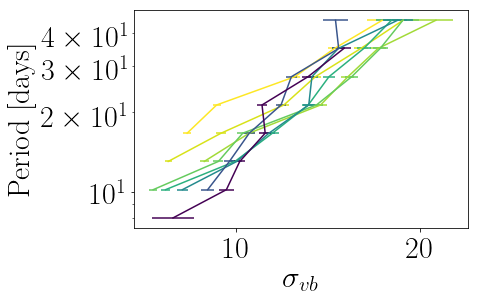

In [15]:
nf = np.load("sigma_vb_data.npz")

for i in range(8):
    plt.errorbar(nf["arr_0"][:, i], nf["arr_3"], xerr=nf["arr_1"][:, i], color=rgba[i])
    
xs = np.linspace(0, 22, 100)
# plt.plot(xs, xs**.5, "k-")
plt.xlabel("$\sigma_{vb}$")
plt.ylabel("$\mathrm{Period~[days]}$")
plt.yscale("log")

In [17]:
# data = pd.DataFrame(dict({"sigma_vb": pds,
#                           "sigma_vb_err": pderrs,
#                           "teff": np.diff(tbins)*.5+tbins[:-1],
#                           "prot": mid_period_bins}))
# data.to_csv("velocity_dispersions.csv")

In [18]:
# vmin, vmax = np.min(ds[ds > 0]), np.max(ds[np.isfinite(ds)])
# color_values = (ds - vmin)/(vmax - vmin)
# rgba = cmap(color_values)

In [19]:
cmap = plt.cm.get_cmap('plasma_r')
pvmin, pvmax = np.min(pds[pds > 0]), np.max(pds[np.isfinite(pds)])
pcolor_values = (pds - pvmin)/(pvmax - pvmin)
prgba_plasma = cmap(pcolor_values)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Calculate a 1.1 Gyr gyrochrone.

In [20]:
from stardate.lhf import gk_rotation_model
from photometric_teff import bprp_to_teff

xs_bprp = np.linspace(.8, 2.8, 100)
log10_age, a_5, a1, a2, a3, a4, a5, a6 = np.log10(1.1*1e9), np.log10(.5*1e9), np.log10(1*1e9), \
    np.log10(2*1e9), np.log10(3*1e9), np.log10(4*1e9), np.log10(5*1e9), np.log10(6*1e9)
log10_age_praesepe = np.log10(.65*1e9)
prots = 10**gk_rotation_model(log10_age, xs_bprp)
p2 = 10**gk_rotation_model(a2, xs_bprp)
p3 = 10**gk_rotation_model(a3, xs_bprp)
p4 = 10**gk_rotation_model(a4, xs_bprp)
p5 = 10**gk_rotation_model(a5, xs_bprp)
p6 = 10**gk_rotation_model(a6, xs_bprp)
p_5 = 10**gk_rotation_model(a_5, xs_bprp)
p1 = 10**gk_rotation_model(a1, xs_bprp)


prots_praesepe = 10**gk_rotation_model(log10_age_praesepe, xs_bprp)
xs_teff = bprp_to_teff(xs_bprp)

ModuleNotFoundError: No module named 'photometric_teff'

niter =  1 0 stars removed kurtosis =  -0.8636434487949445
niter =  3 2 stars removed kurtosis =  0.2805248570163159
niter =  3 4 stars removed kurtosis =  -0.3548264796263214
niter =  2 5 stars removed kurtosis =  -0.3615965110556689
niter =  2 2 stars removed kurtosis =  -0.20273354051278591
niter =  1 0 stars removed kurtosis =  -0.038151212819649505
niter =  1 0 stars removed kurtosis =  -0.39669311199806856
niter =  1 0 stars removed kurtosis =  -0.6816389072438054


NameError: name 'prots_praesepe' is not defined

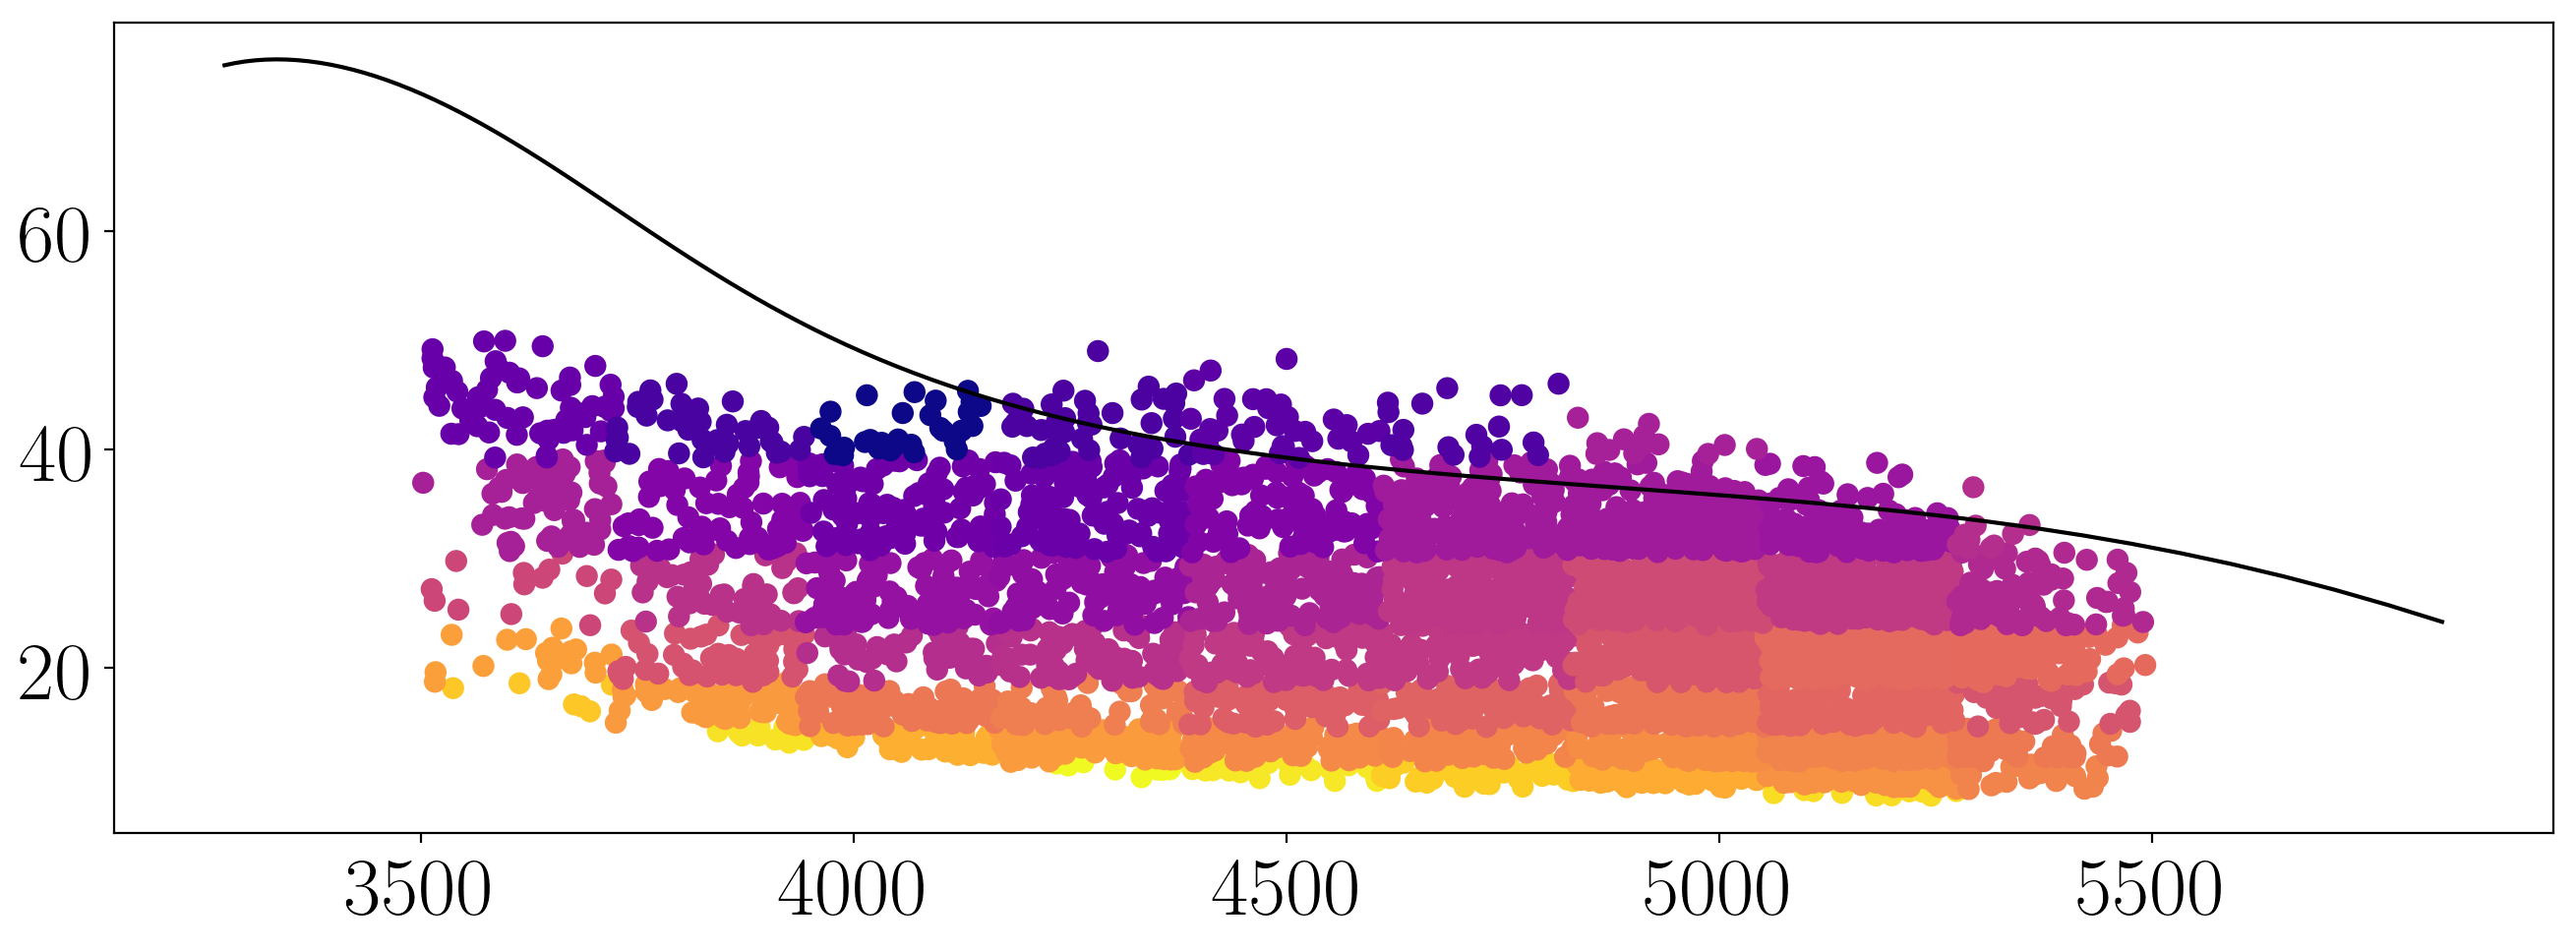

In [21]:
plt.rcParams.update({'legend.fontsize': 18})

fig = plt.figure(figsize=(16, 12), dpi=200)
ax3 = fig.add_subplot(211)

# ax3.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".5", rasterized=True, zorder=0, label=None)

# for i, m in enumerate(age_masks):
for i, m in enumerate(period_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    
    for j in range(len(tbins)-1):
        tm = (x[m][clipping_mask] > tbins[j]) * (x[m][clipping_mask] < tbins[j+1])
        cb1 = plt.scatter(x[m][clipping_mask][tm], y[m][clipping_mask][tm],
                          c=np.ones_like(y[m][clipping_mask][tm])*pds[i, j],
#                           c=np.ones_like(y[m][clipping_mask][tm])*ds[i, j],
                          vmin=pvmin, vmax=pvmax,
                          rasterized=True, zorder=1, s=50, cmap="plasma_r")

# 1.1 Gyr Gyrochrone        
plt.plot(xs_teff, prots, color="k", zorder=10, label="$\mathrm{1.1~Gyr~model~(the~gap)}$")
plt.plot(xs_teff, prots_praesepe, color="k", ls=":", zorder=10, label="$\mathrm{650~Myr~model~(Praesepe)}$")

# NGC 6811
df = pd.read_csv("NGC6811.csv")
plt.plot(df.teff, df.prot, "k.", zorder=9, label="$\mathrm{NGC~6811~(\sim1.1~Gyr)}$")

# ax3.legend()
plt.legend(bbox_to_anchor=(0., .92, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)
plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
# ax1.xlabel("$\mathrm{T_{eff}~[K]}$")
ax3.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax3.set_xlim(5750, xlim[1])
ax3.set_yscale("log")
ax3.set_ylim(7, 65)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = fig.add_subplot(212, sharex=ax3)
# plt.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".1", alpha=.1, ms=2,
#          mec="none", rasterized=True, zorder=1)
# plt.plot(gaia_mc.color_teffs, gaia_mc.Prot, "ko", mec="k", ms=.5, 
#          alpha=.2, rasterized=True, zorder=3)

for i, m in enumerate(period_masks):
#     ax4.axhline(period_bins[i], color="k", ls="--")
    
#     v_clipped, clipping_mask = sigma_clip(v[m], 3)
#     for j in range(len(tbins)-1):
#         tm = (x[m][clipping_mask] > tbins[j]) * (x[m][clipping_mask] < tbins[j+1])
#         cb1 = plt.scatter(x[m][clipping_mask][tm], y[m][clipping_mask][tm],
#                           c=np.ones_like(y[m][clipping_mask][tm])*pds[i, j],
#                           vmin=pvmin, vmax=pvmax, # edgecolor="k",
#                           rasterized=True, zorder=2, s=.01, cmap="plasma_r")
        
    for j in range(len(tbins)-1):
        tm = (x[m] > tbins[j]) * (x[m] < tbins[j+1])
        cb1 = plt.scatter(x[m][tm], y[m][tm], c=np.ones_like(y[m][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax, rasterized=True, zorder=2, s=.01, cmap="plasma_r")
        xs = np.linspace(tbins[j], tbins[j+1], 10)
        color = prgba_plasma[i, j]
        if not np.isfinite(pds[i, j]):
            color = "w"
        ax4.fill_between(xs, np.ones_like(xs)*period_bins[i], np.ones_like(xs)*period_bins[i+1],
                         color=color, zorder=1)
# ax4.fill_between(np.linspace(3000, tbins[2], 100), np.ones(100)*1, np.ones(100)*200,
#                  hatch="/", zorder=20, edgecolor="k", facecolor="none")
# ax4.axhline(period_bins[-1], color="k", ls="--")
# for t in tbins:
#     ax4.axvline(t, color="k", ls="--")

# 1.1 Gyr Gyrochrone        
plt.plot(xs_teff, prots, color="k", zorder=10)
plt.plot(xs_teff, prots_praesepe, color="k", ls=":", zorder=10, label="$\mathrm{650~Myr~(Praesepe)}$")

plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
ax4.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax4.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax4.set_yscale("log")
ax4.set_ylim(7, 65)
# plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig("paper/vplot.pdf")

niter =  1 0 stars removed kurtosis =  -0.8636434487949445
niter =  3 2 stars removed kurtosis =  0.2805248570163159
niter =  3 4 stars removed kurtosis =  -0.3548264796263214
niter =  2 5 stars removed kurtosis =  -0.3615965110556689
niter =  2 2 stars removed kurtosis =  -0.20273354051278591
niter =  1 0 stars removed kurtosis =  -0.038151212819649505
niter =  1 0 stars removed kurtosis =  -0.39669311199806856
niter =  1 0 stars removed kurtosis =  -0.6816389072438054


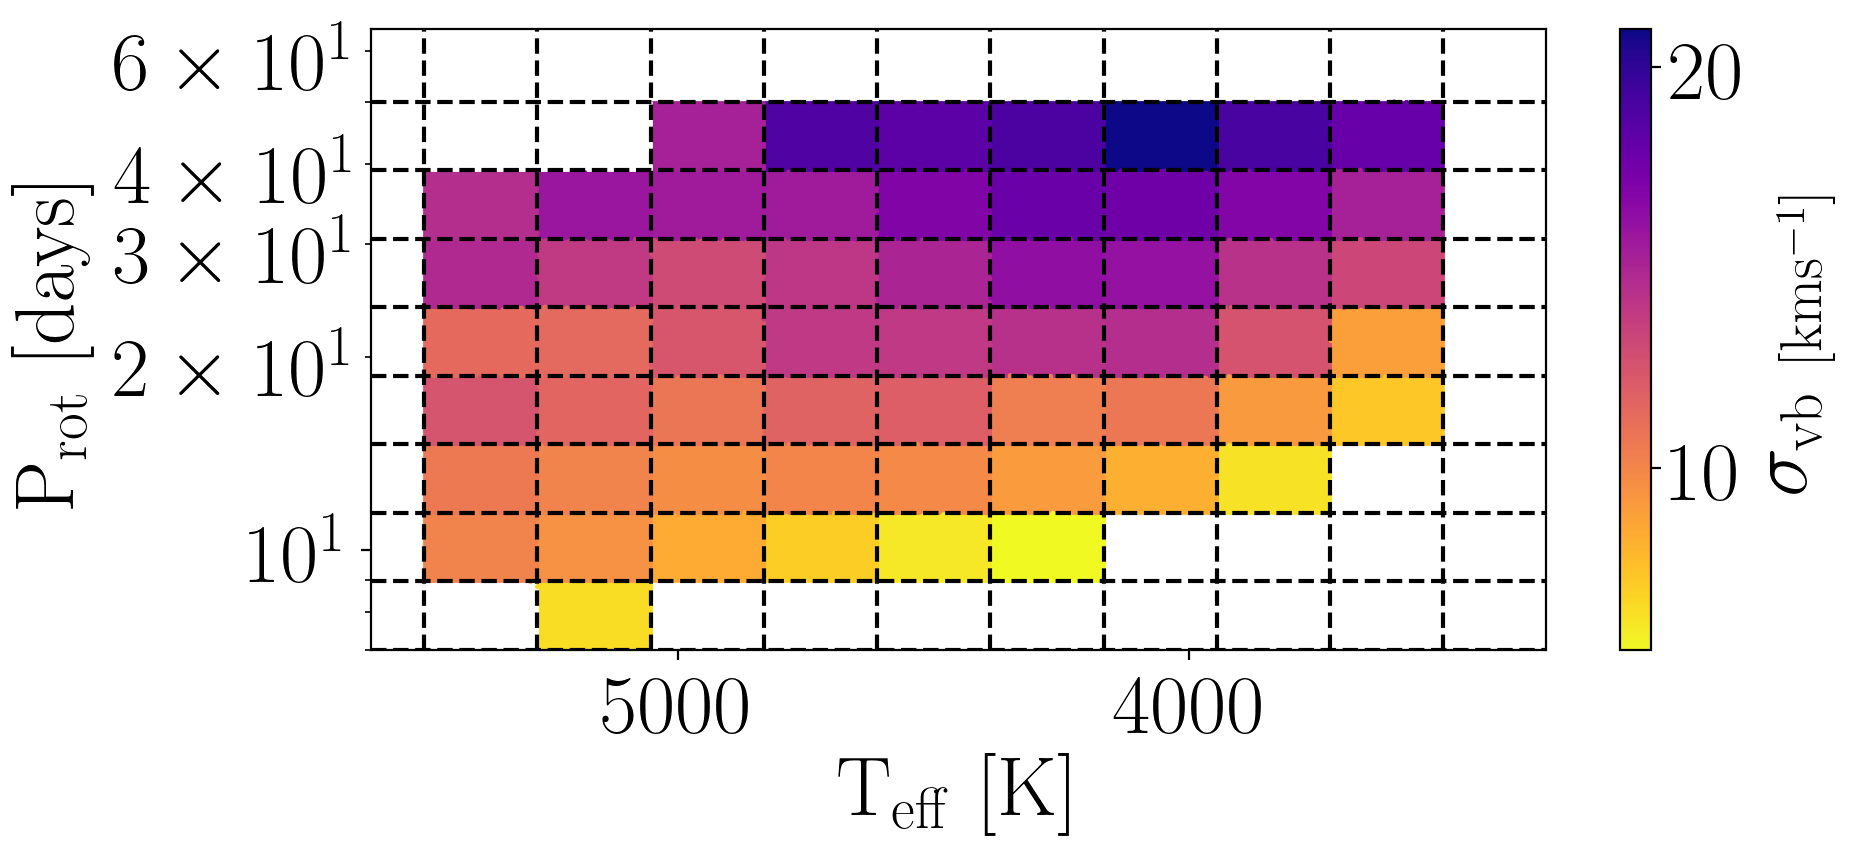

In [22]:
plt.figure(figsize=(10, 5), dpi=200)
# plt.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".1", alpha=.1, ms=2,
#          mec="none", rasterized=True, zorder=1)
# plt.plot(gaia_mc.color_teffs, gaia_mc.Prot, "ko", mec="k", ms=.5, 
#          alpha=.2, rasterized=True, zorder=3)

for i, m in enumerate(period_masks):
    plt.axhline(period_bins[i], color="k", ls="--")
    
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    
    for j in range(len(tbins)-1):
        tm = (x[m][clipping_mask] > tbins[j]) * (x[m][clipping_mask] < tbins[j+1])
        cb1 = plt.scatter(x[m][clipping_mask][tm], y[m][clipping_mask][tm],
                          c=np.ones_like(y[m][clipping_mask][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax,
                          rasterized=True, zorder=2, s=1, cmap="plasma_r")
        
        xs = np.linspace(tbins[j], tbins[j+1], 10)
        color = prgba_plasma[i, j]
        if not np.isfinite(pds[i, j]):
            color = "w"
        plt.fill_between(xs, np.ones_like(xs)*period_bins[i], np.ones_like(xs)*period_bins[i+1],
                         color=color, zorder=1)
        
plt.axhline(period_bins[-1], color="k", ls="--")
for t in tbins:
    plt.axvline(t, color="k", ls="--")

plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.xlim(xlim)
plt.yscale("log")
plt.ylim(7, 65)
plt.tight_layout()
# plt.savefig("paper/dispersion_period_teff.pdf")

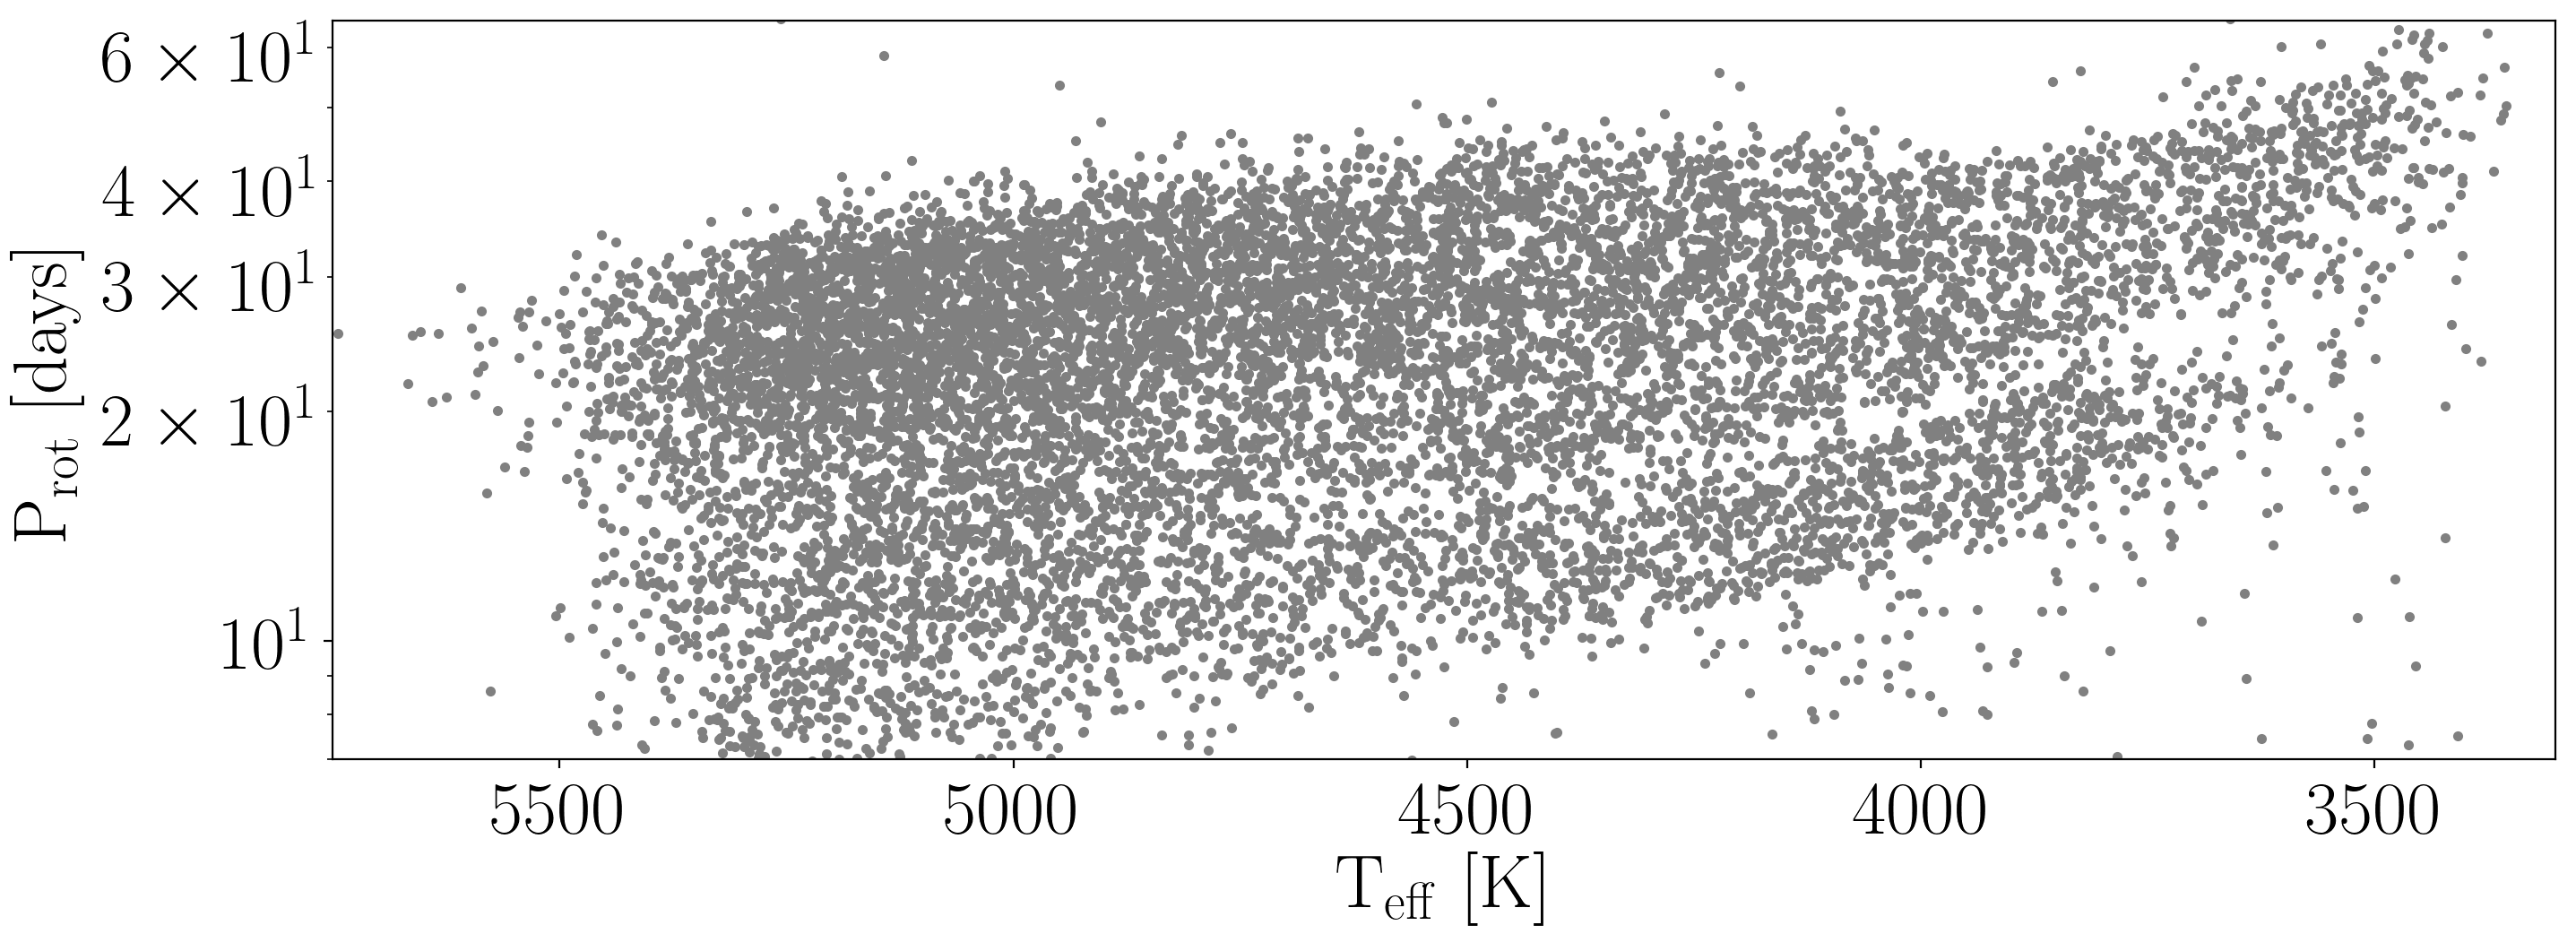

In [23]:
fig = plt.figure(figsize=(16, 12), dpi=200)
ax3 = fig.add_subplot(211)
ax3.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".5", rasterized=True, zorder=0, label=None)

ax3.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax3.set_xlim(5750, xlim[1])
ax3.set_yscale("log")
ax3.set_ylim(7, 65)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.savefig("simple_vb_no_color.pdf")

niter =  1 0 stars removed kurtosis =  -0.8636434487949445
niter =  3 2 stars removed kurtosis =  0.2805248570163159
niter =  3 4 stars removed kurtosis =  -0.3548264796263214
niter =  2 5 stars removed kurtosis =  -0.3615965110556689
niter =  2 2 stars removed kurtosis =  -0.20273354051278591
niter =  1 0 stars removed kurtosis =  -0.038151212819649505
niter =  1 0 stars removed kurtosis =  -0.39669311199806856
niter =  1 0 stars removed kurtosis =  -0.6816389072438054


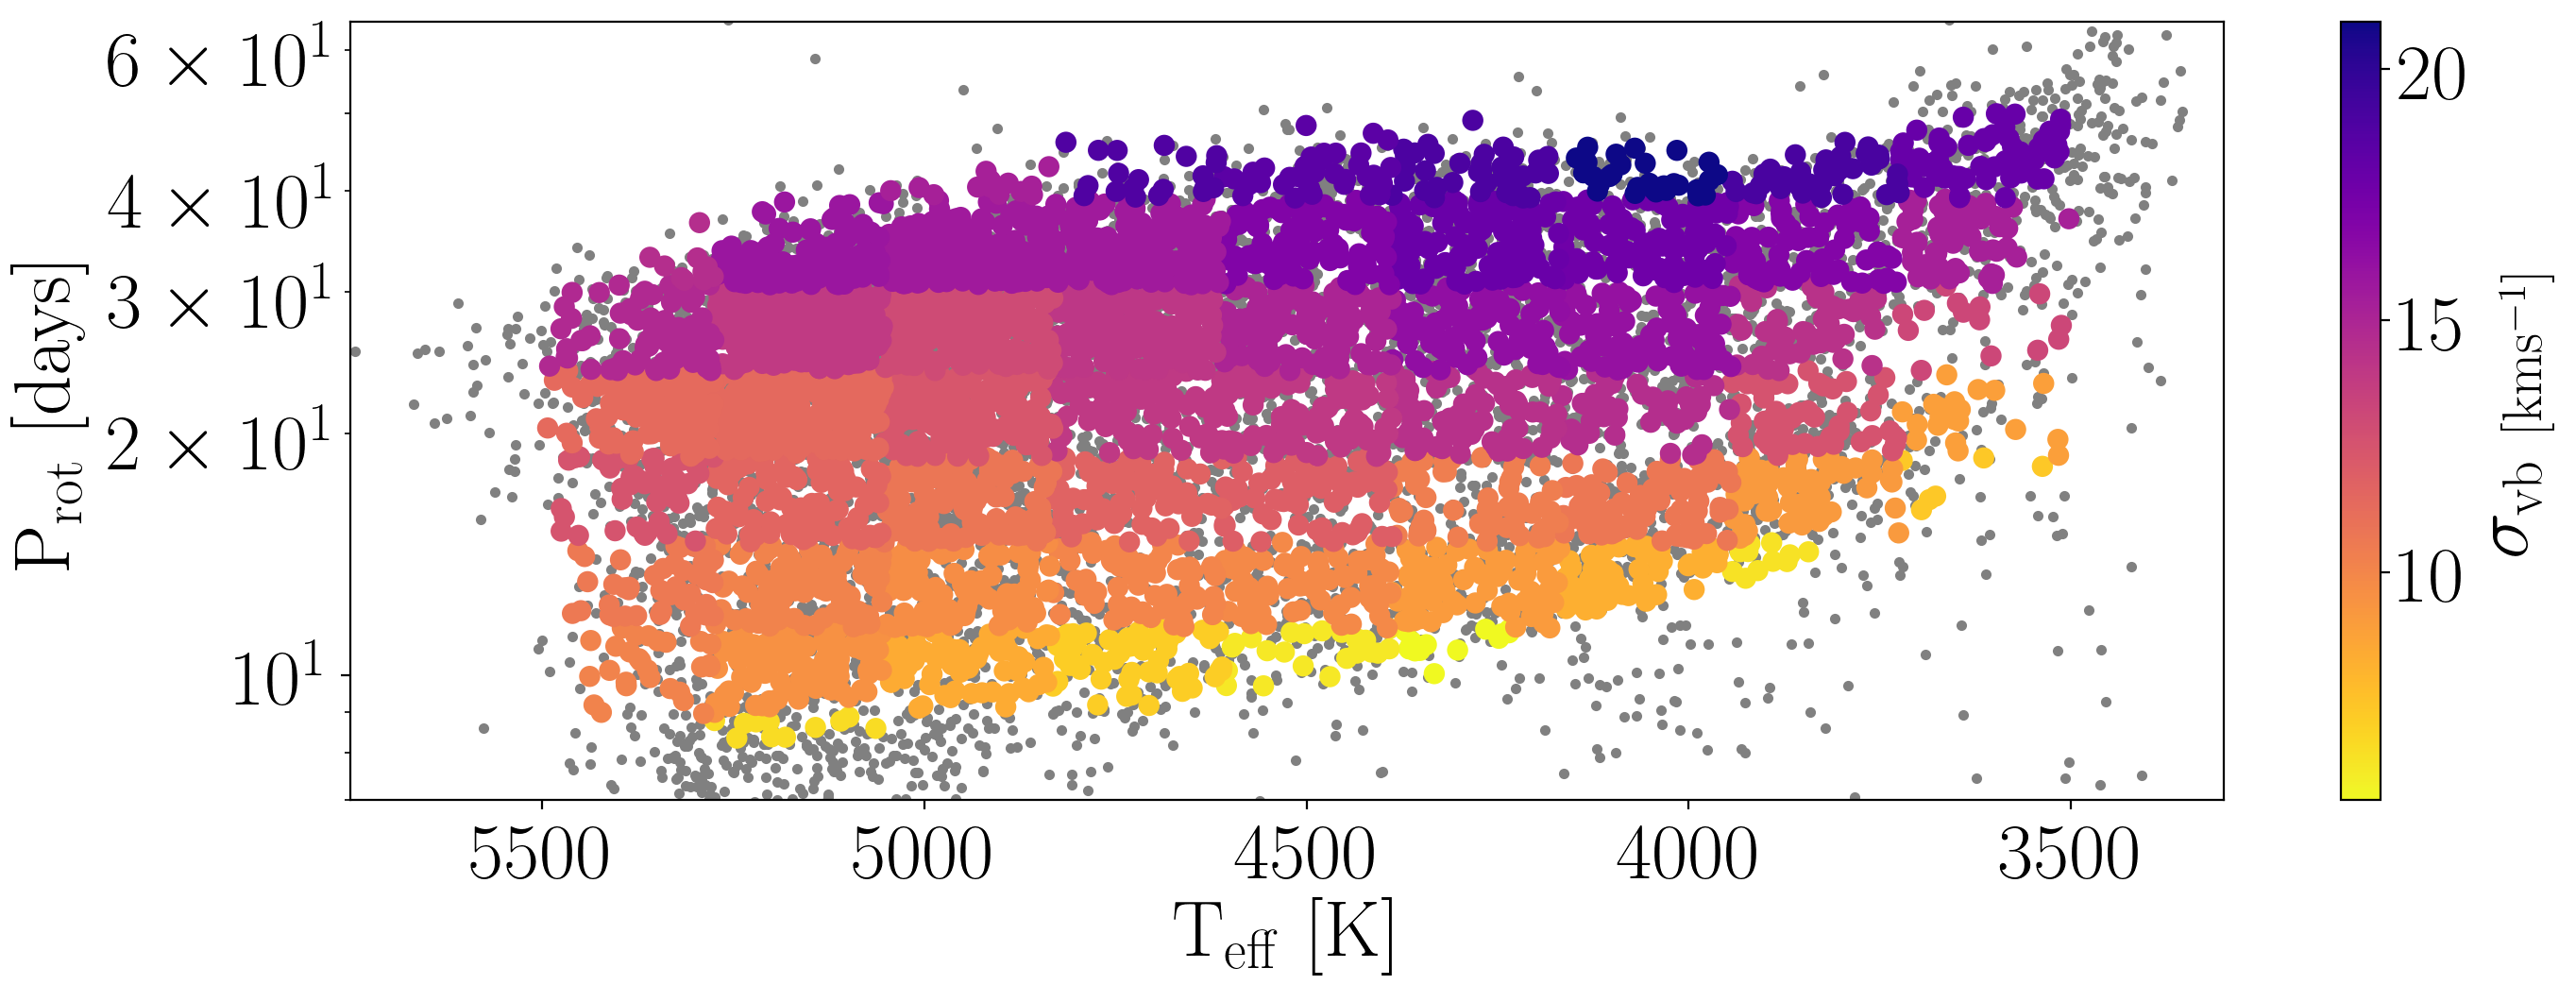

In [24]:
plt.rcParams.update({'legend.fontsize': 18})

fig = plt.figure(figsize=(16, 12), dpi=200)
ax3 = fig.add_subplot(211)
ax3.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".5", rasterized=True, zorder=0, label=None)

# for i, m in enumerate(age_masks):
for i, m in enumerate(period_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    
    for j in range(len(tbins)-1):
        tm = (x[m][clipping_mask] > tbins[j]) * (x[m][clipping_mask] < tbins[j+1])
        cb1 = plt.scatter(x[m][clipping_mask][tm], y[m][clipping_mask][tm],
                          c=np.ones_like(y[m][clipping_mask][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax,
                          rasterized=True, zorder=1, s=50, cmap="plasma_r")

plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
ax3.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax3.set_xlim(5750, xlim[1])
ax3.set_yscale("log")
ax3.set_ylim(7, 65)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.savefig("simple_vb_plot.pdf")

niter =  1 0 stars removed kurtosis =  -0.8636434487949445
niter =  3 2 stars removed kurtosis =  0.2805248570163159
niter =  3 4 stars removed kurtosis =  -0.3548264796263214
niter =  2 5 stars removed kurtosis =  -0.3615965110556689
niter =  2 2 stars removed kurtosis =  -0.20273354051278591
niter =  1 0 stars removed kurtosis =  -0.038151212819649505
niter =  1 0 stars removed kurtosis =  -0.39669311199806856
niter =  1 0 stars removed kurtosis =  -0.6816389072438054


NameError: name 'p_5' is not defined

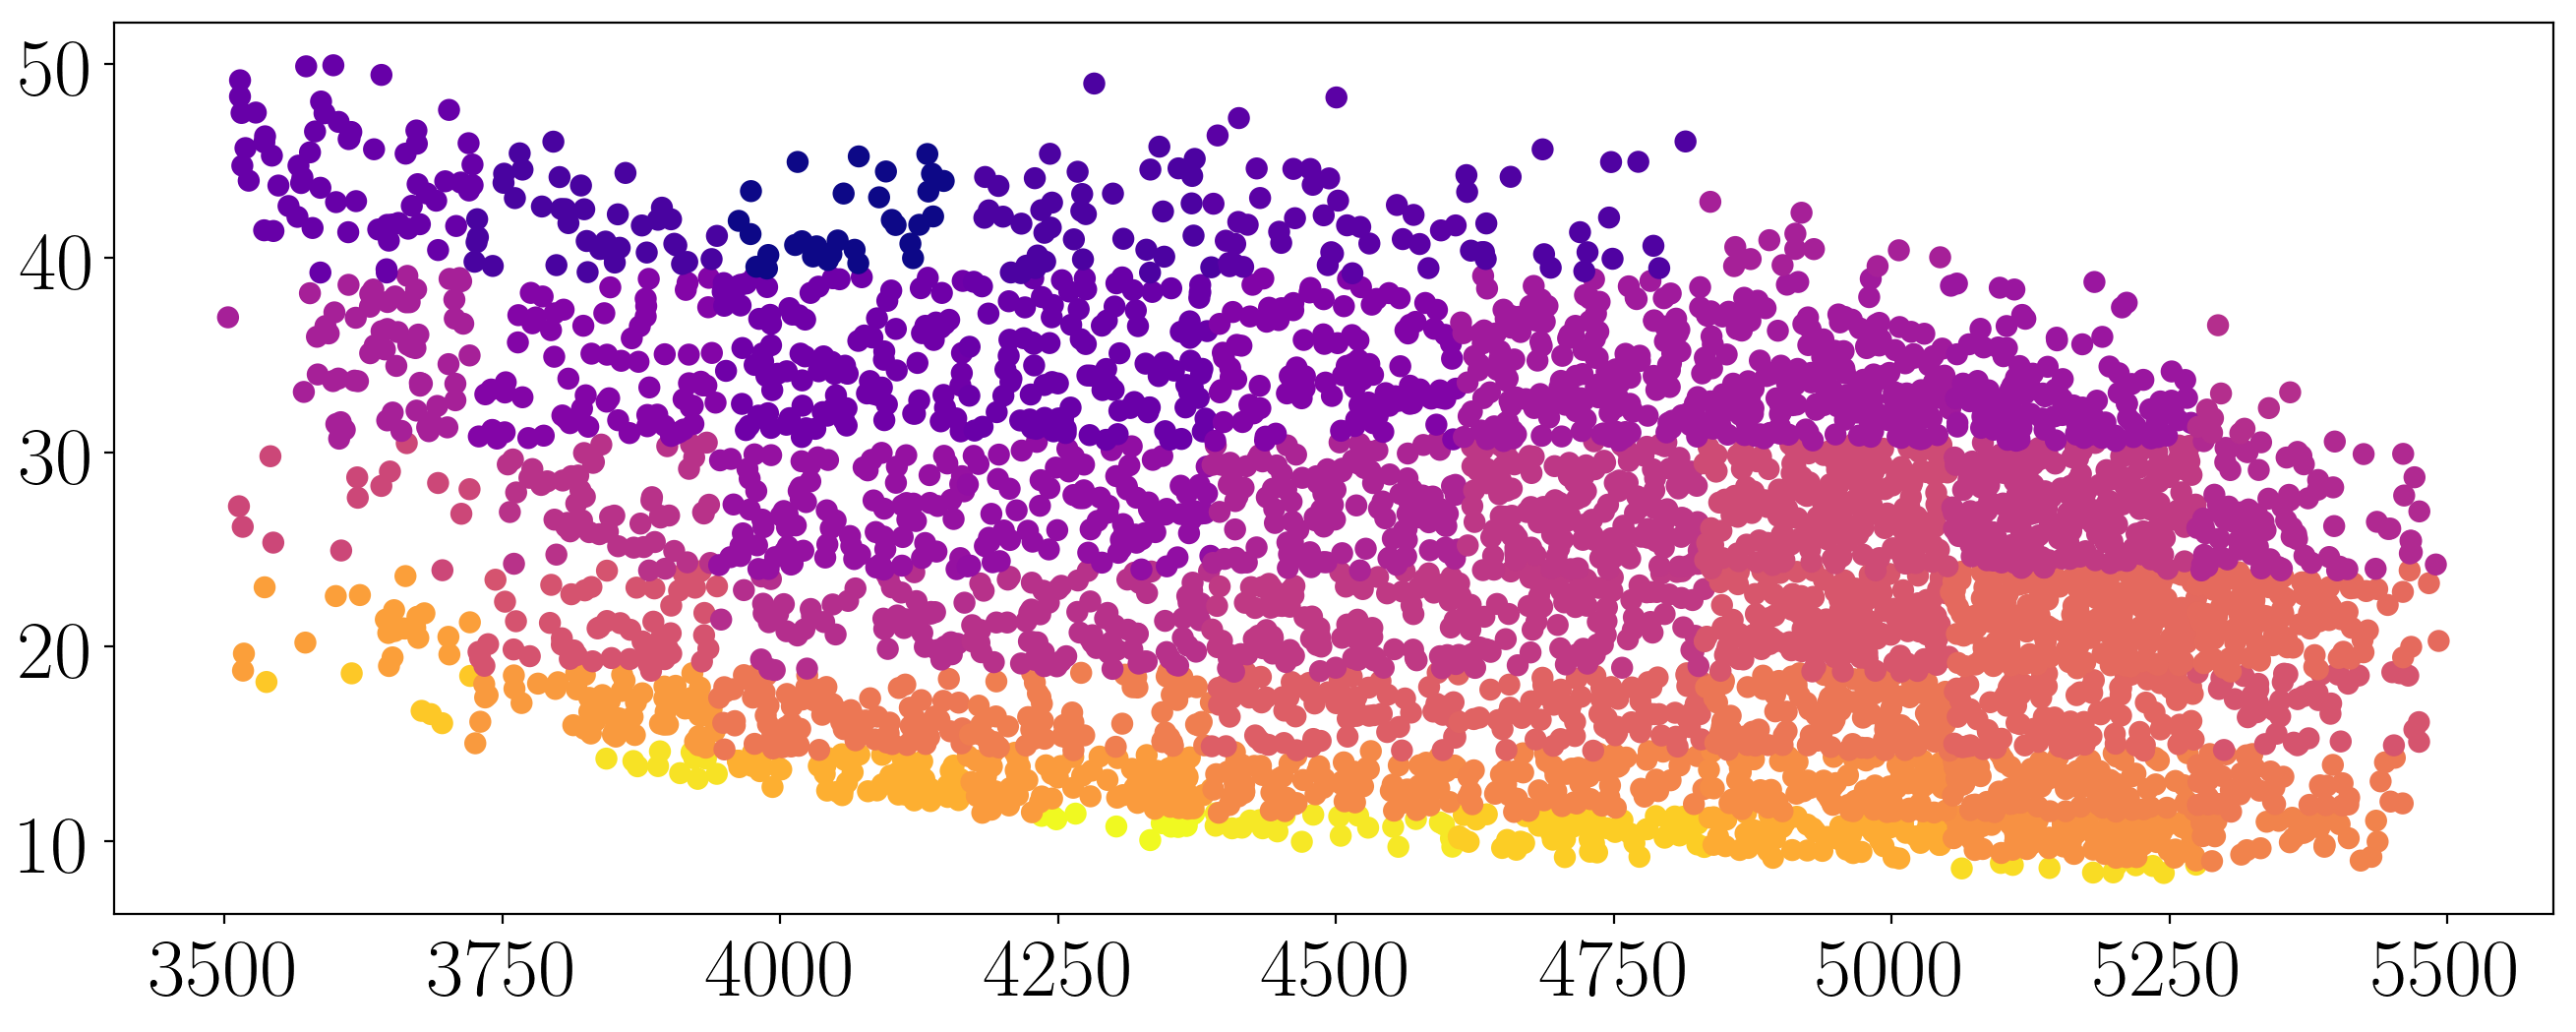

In [25]:
fig = plt.figure(figsize=(16, 6), dpi=200)
ax3 = fig.add_subplot(111)

for i, m in enumerate(period_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    
    for j in range(len(tbins)-1):
        tm = (x[m][clipping_mask] > tbins[j]) * (x[m][clipping_mask] < tbins[j+1])
        cb1 = plt.scatter(x[m][clipping_mask][tm], y[m][clipping_mask][tm],
                          c=np.ones_like(y[m][clipping_mask][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax,
                          rasterized=True, zorder=0, s=50, cmap="plasma_r")

# 1.1 Gyr Gyrochrone
# plt.plot(xs_teff, prots, color="w", zorder=1, lw=3)
# plt.plot(xs_teff, prots_praesepe, color="w", zorder=1, lw=3)
# plt.plot(xs_teff, p2, color="w", zorder=1, lw=3)
# plt.plot(xs_teff, p3, color="w", zorder=1, lw=3)
# plt.plot(xs_teff, p5, color="w", zorder=1, lw=3)

plt.plot(xs_teff, p_5, color="k", ls=":", zorder=2, label="$\mathrm{0.5~Gyr}$")
plt.plot(xs_teff, p1, color="k", ls="-.", zorder=2, label="$\mathrm{1~Gyr}$")
plt.plot(xs_teff, p2, color="k", zorder=2, ls="--", label="$\mathrm{2~Gyr}$")
plt.plot(xs_teff, p3, color="k", zorder=2, ls="-", label="$\mathrm{3~Gyr}$")
# plt.plot(xs_teff, p4, color="k", zorder=10, ls="--", label="$\mathrm{4~Gyr}$")
plt.plot(xs_teff, p5, color="k", zorder=2, ls="--", label="$\mathrm{5~Gyr}$")
# plt.plot(xs_teff, p6, color="k", zorder=10, ls="--", label="$\mathrm{6~Gyr}$")


# ax3.legend()
plt.legend(bbox_to_anchor=(0., .92, 1., .102), loc=3, ncol=6, mode="expand",
           borderaxespad=0., framealpha=.999)
plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
ax3.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax3.set_xlim(5750, xlim[1])
ax3.set_yscale("log")
ax3.set_ylim(7, 65)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.tight_layout()
plt.savefig("simple_vb_with_models.pdf")
plt.savefig("simple_vb_with_models")

In [ ]:
plt.plot()

niter =  1 0 stars removed kurtosis =  -0.8636434487949445
niter =  3 2 stars removed kurtosis =  0.2805248570163159
niter =  3 4 stars removed kurtosis =  -0.3548264796263214
niter =  2 5 stars removed kurtosis =  -0.3615965110556689
niter =  2 2 stars removed kurtosis =  -0.20273354051278591
niter =  1 0 stars removed kurtosis =  -0.038151212819649505
niter =  1 0 stars removed kurtosis =  -0.39669311199806856
niter =  1 0 stars removed kurtosis =  -0.6816389072438054


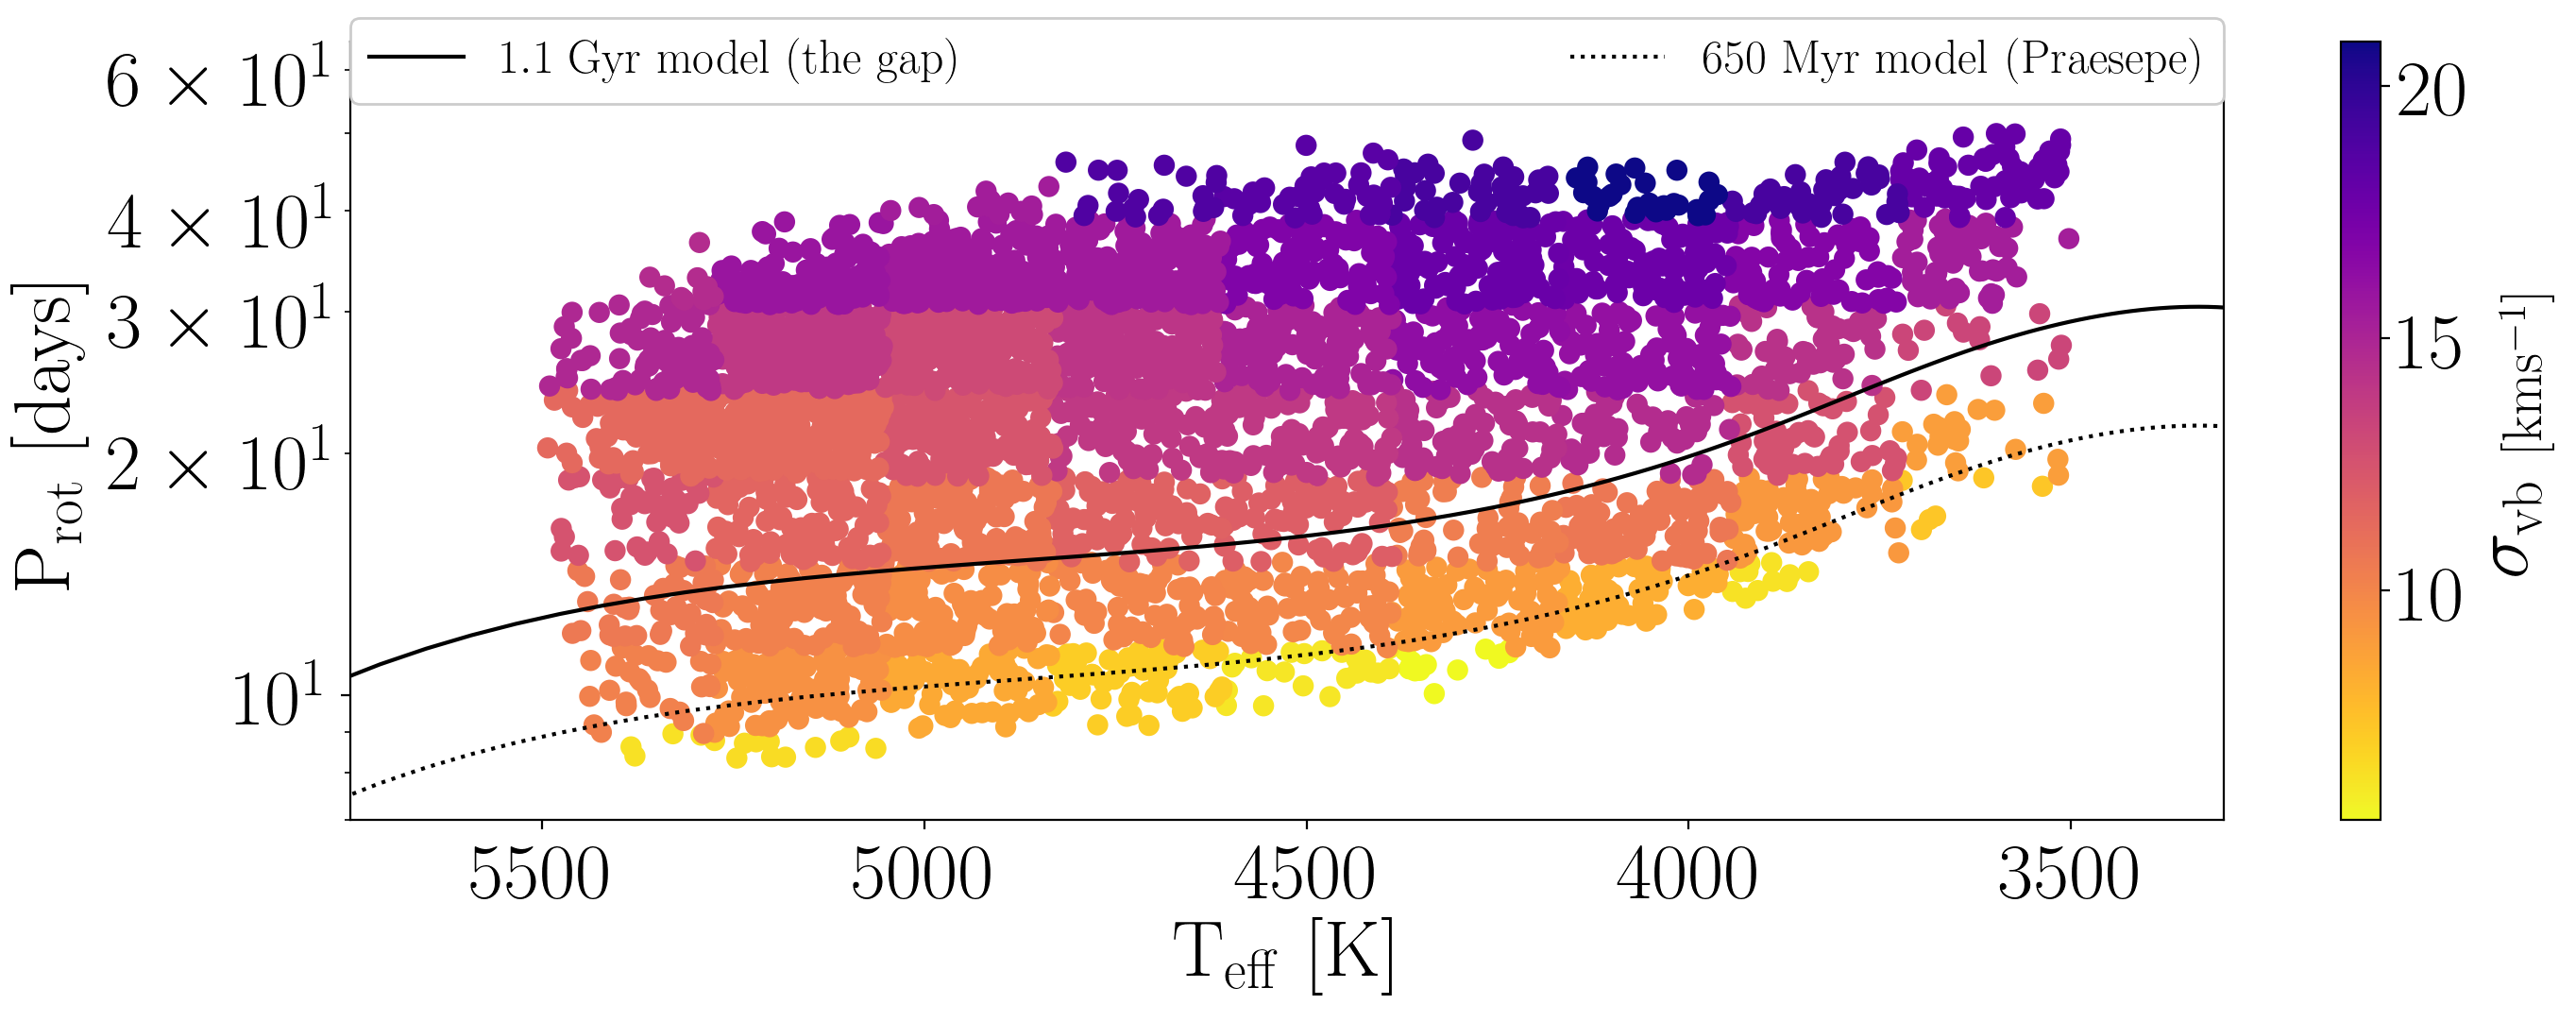

In [27]:
fig = plt.figure(figsize=(16, 12), dpi=200)
ax3 = fig.add_subplot(211)

for i, m in enumerate(period_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    
    for j in range(len(tbins)-1):
        tm = (x[m][clipping_mask] > tbins[j]) * (x[m][clipping_mask] < tbins[j+1])
        cb1 = plt.scatter(x[m][clipping_mask][tm], y[m][clipping_mask][tm],
                          c=np.ones_like(y[m][clipping_mask][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax,
                          rasterized=True, zorder=1, s=50, cmap="plasma_r")

# 1.1 Gyr Gyrochrone        
plt.plot(xs_teff, prots, color="k", zorder=10, label="$\mathrm{1.1~Gyr~model~(the~gap)}$")
plt.plot(xs_teff, prots_praesepe, color="k", ls=":", zorder=10, label="$\mathrm{650~Myr~model~(Praesepe)}$")

# NGC 6811
df = pd.read_csv("NGC6811.csv")
# plt.plot(df.teff, df.prot, "k.", zorder=9, label="$\mathrm{NGC~6811~(\sim1.1~Gyr)}$")

# ax3.legend()
plt.legend(bbox_to_anchor=(0., .92, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)
plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
# ax1.xlabel("$\mathrm{T_{eff}~[K]}$")
ax3.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax3.set_xlim(5750, xlim[1])
ax3.set_yscale("log")
ax3.set_ylim(7, 65)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.savefig("simple_vb_with_cluster.pdf")

Text(0.5, 0, '$\\mathrm{T_{eff}~[K]}$')

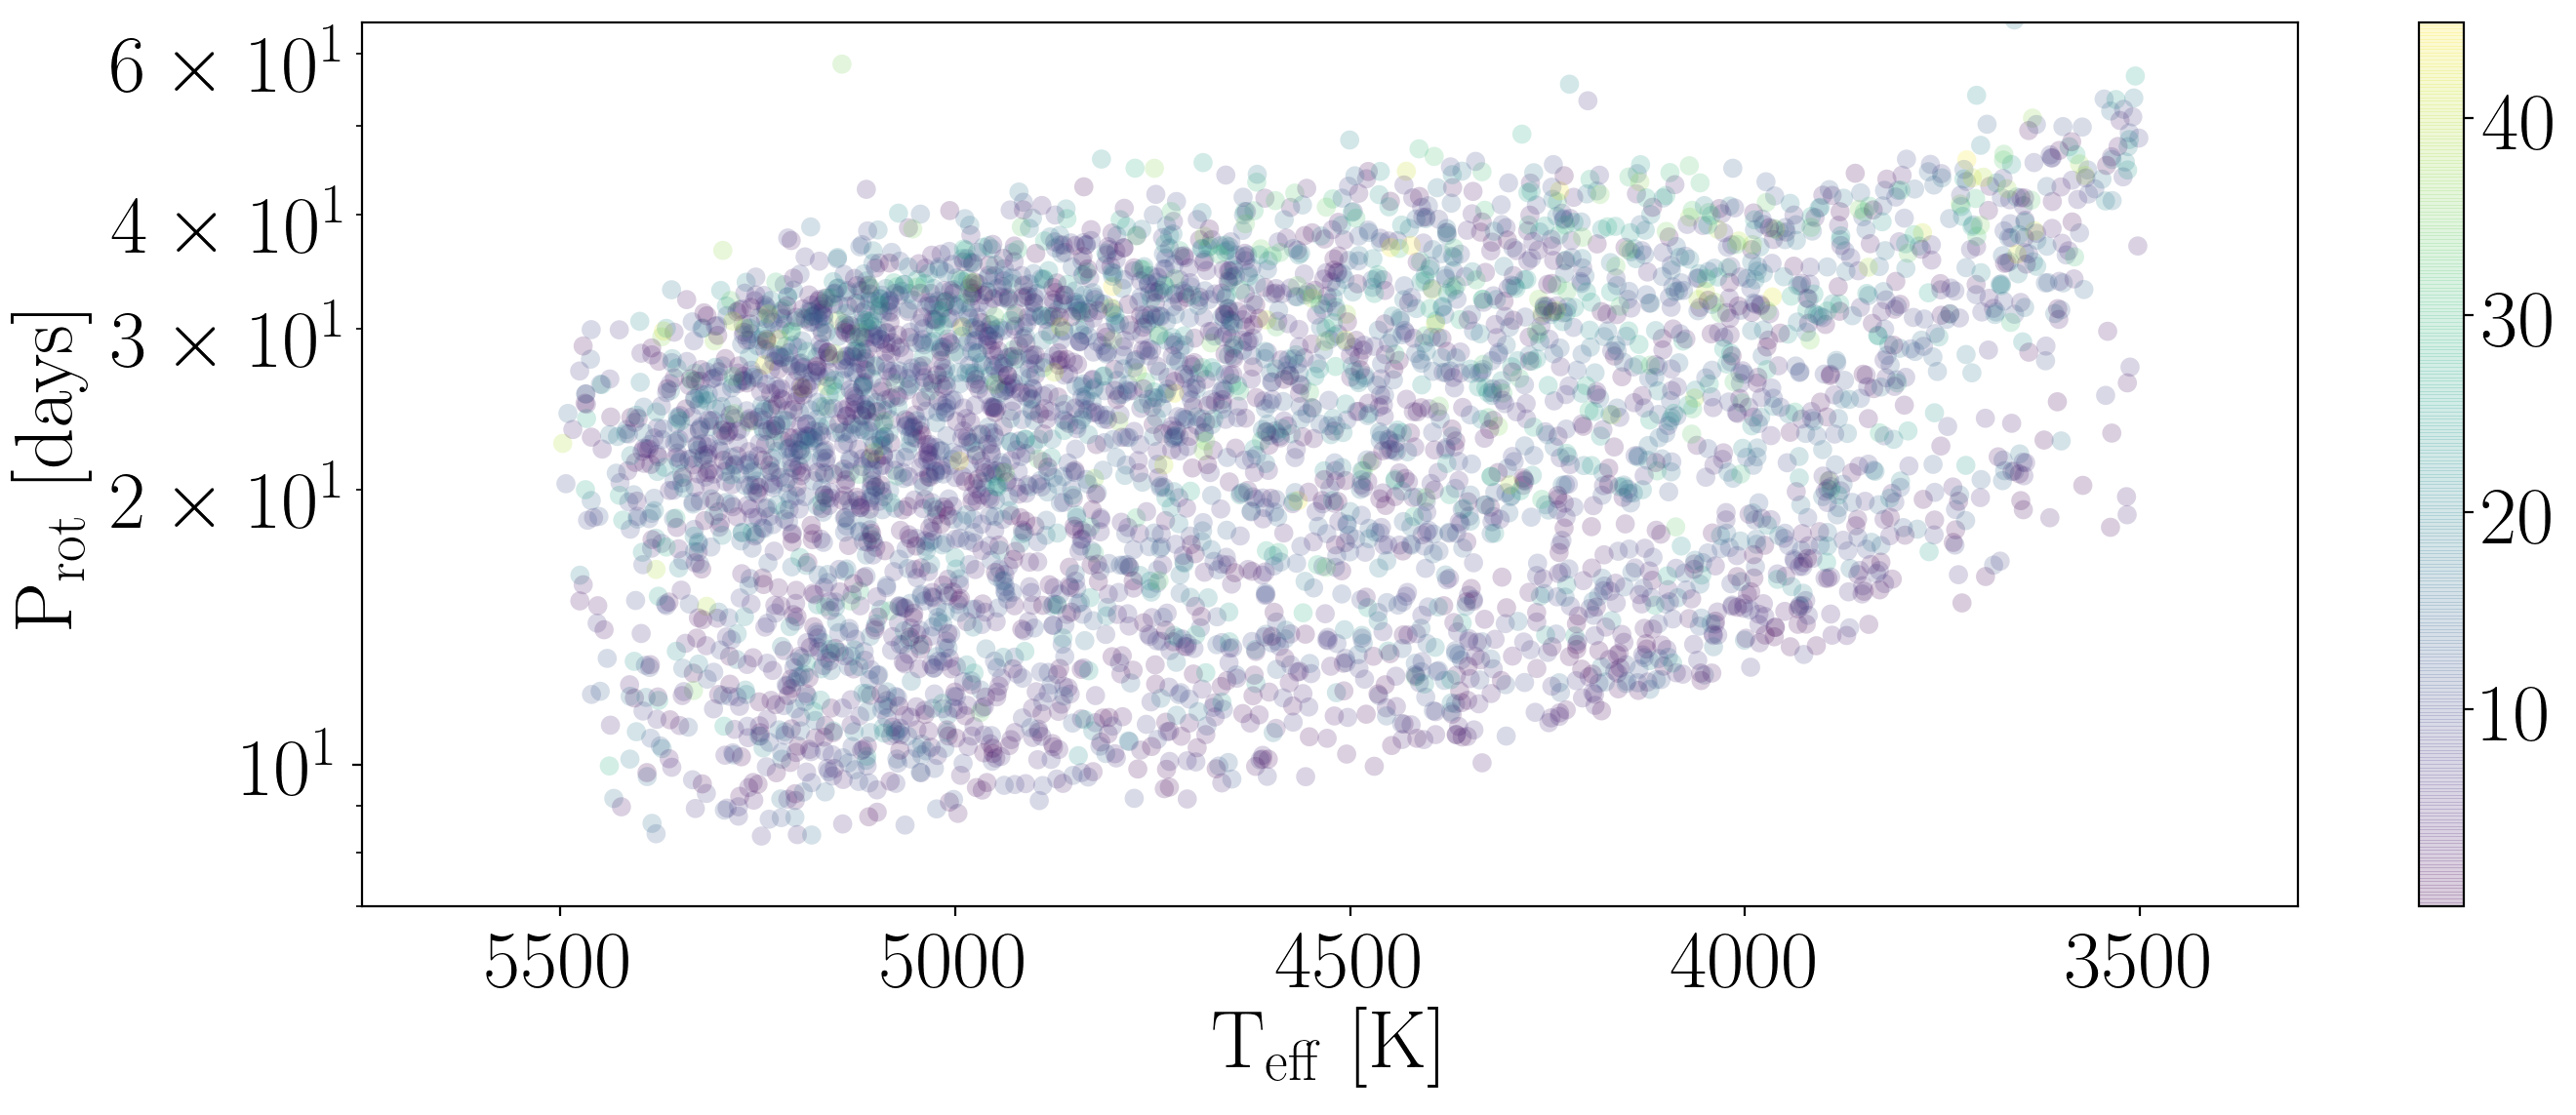

In [28]:
fig = plt.figure(figsize=(16, 6), dpi=200)
plt.scatter(gaia_mc.color_teffs, gaia_mc.Prot, c=abs(gaia_mc.vb),
            alpha=.2, edgecolor="none", s=50, rasterized=True)

plt.colorbar()
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.xlim(5750, xlim[1])
plt.yscale("log")
plt.ylim(7, 65)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")

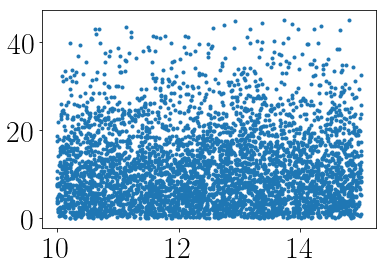

In [29]:
plt.plot(gaia_mc.b, np.abs(gaia_mc.vb), ".")

In [30]:
import teff_bv as tb

sl = pd.read_csv("spada_lanzafame_models.csv")
sl.head()
# sl["teff"] = tb.bv

Mass  (B−V)  p0.10  p0.12  p0.15  p0.20  p0.22  p0.25  p0.30  p0.40  p0.50  \
0  0.45  1.477   9.69   9.76  10.96  14.87  15.95  17.09  18.24  19.99  21.54   
1  0.50  1.440   9.08   9.28  11.83  14.43  14.99  15.63  16.50  17.80  18.76   
2  0.55  1.390   8.40   9.92  11.54  12.43  12.76  13.24  14.00  15.30  16.18   
3  0.60  1.338   8.26   9.65  10.38  11.25  11.50  11.84  12.28  12.94  13.43   
4  0.65  1.277   8.18   8.60   9.25   9.97  10.16  10.39  10.71  11.22  11.68   

   p0.60  p0.70  p1.00  p1.50  p2.00  p2.50  p4.00  p4.57  
0  22.92  24.18  27.20  29.87  31.13  31.89  33.36  34.40  
1  19.53  20.19  21.68  23.20  24.66  26.12  30.53  32.41  
2  16.69  17.04  17.92  19.47  21.27  23.26  29.81  32.71  
3  13.88  14.30  15.61  17.86  20.20  22.62  30.29  33.25  
4  12.15  12.62  14.12  16.77  19.62  22.62  31.50  34.71

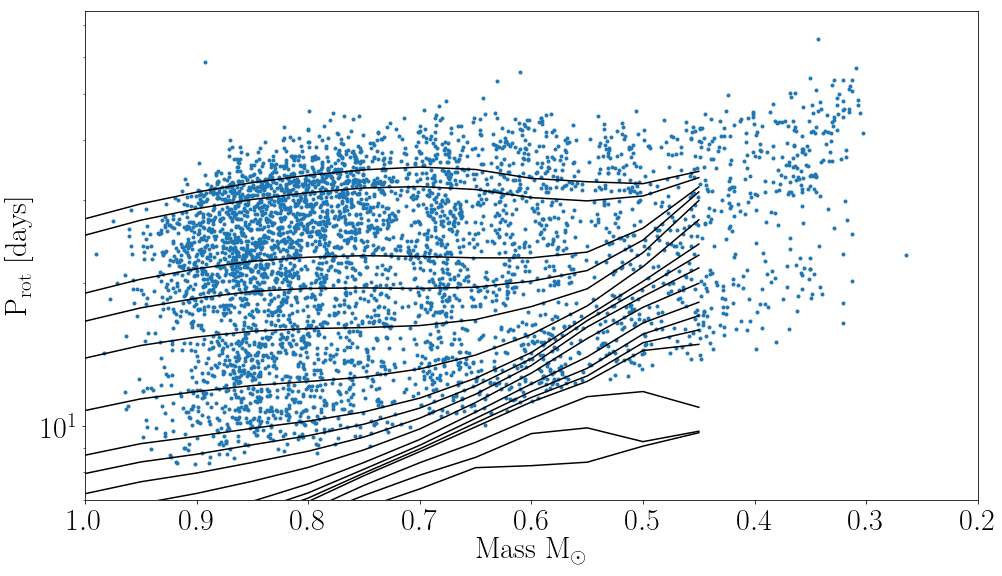

In [31]:
plt.figure(figsize=(16, 9))
plt.plot(gaia_mc.Mass, gaia_mc.Prot, ".")
for c in sl.columns[2:]:
    plt.plot(sl["Mass"], sl["{}".format(c)], "k")

plt.xlim(1., .2)
plt.ylim(7, 75)
plt.xlabel("$\mathrm{Mass~M_\odot}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.yscale("log")

niter =  1 0 stars removed kurtosis =  -0.8636434487949445
niter =  3 2 stars removed kurtosis =  0.2805248570163159
niter =  3 4 stars removed kurtosis =  -0.3548264796263214
niter =  2 5 stars removed kurtosis =  -0.3615965110556689
niter =  2 2 stars removed kurtosis =  -0.20273354051278591
niter =  1 0 stars removed kurtosis =  -0.038151212819649505
niter =  1 0 stars removed kurtosis =  -0.39669311199806856
niter =  1 0 stars removed kurtosis =  -0.6816389072438054


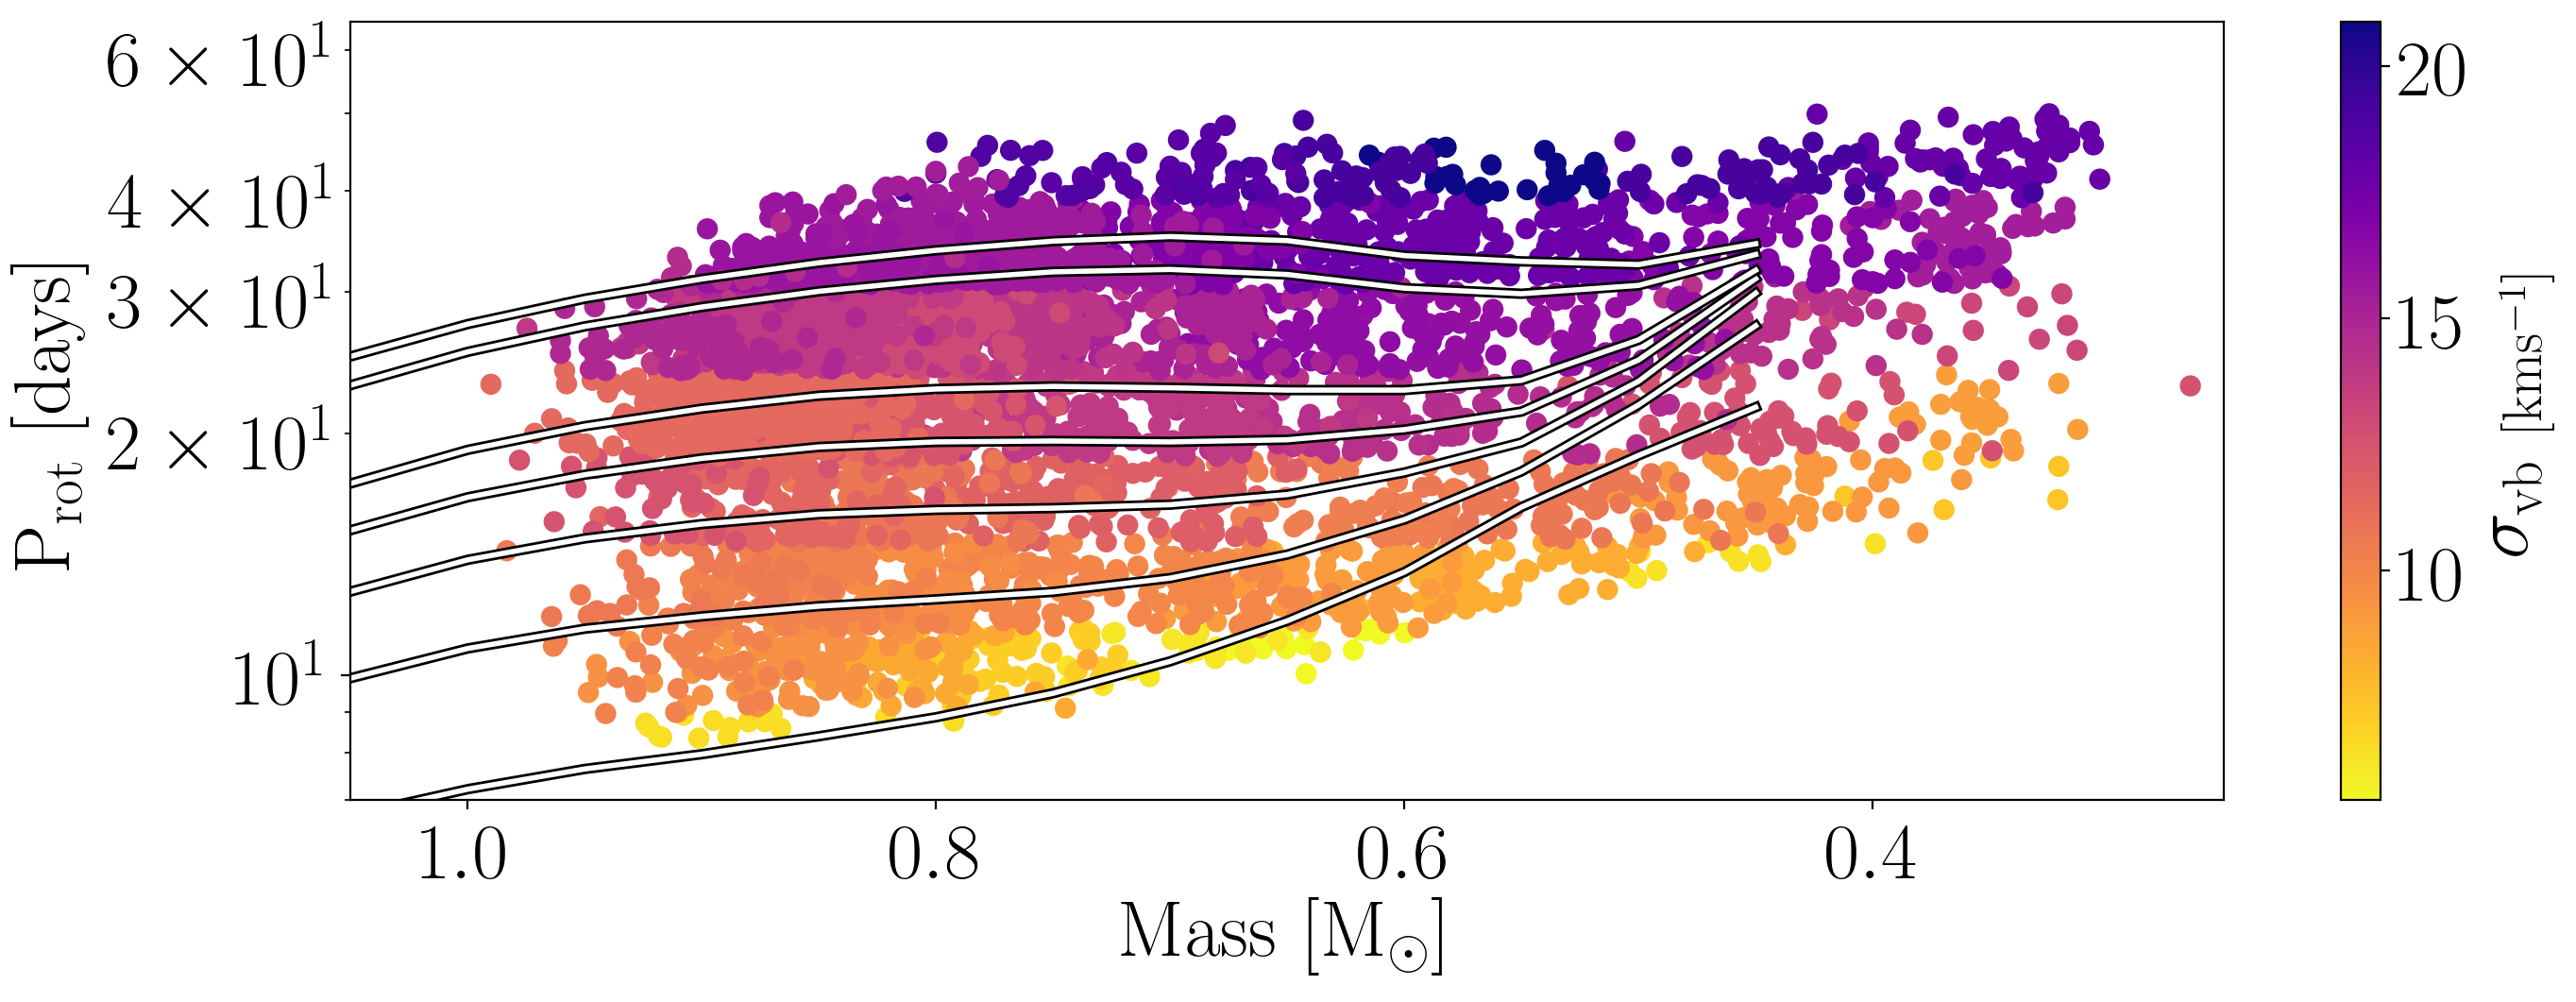

In [32]:
fig = plt.figure(figsize=(16, 12), dpi=200)
ax3 = fig.add_subplot(211)

for i, m in enumerate(period_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    
    for j in range(len(tbins)-1):
        tm = (x[m][clipping_mask] > tbins[j]) * (x[m][clipping_mask] < tbins[j+1])
        cb1 = plt.scatter(gaia_mc.Mass.values[m][clipping_mask][tm], y[m][clipping_mask][tm],
                          c=np.ones_like(y[m][clipping_mask][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax,
                          rasterized=True, zorder=1, s=50, cmap="plasma_r")

plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
ax3.set_ylabel("$\mathrm{P_{rot}~[days]}$")
# ax3.set_xlim(5750, xlim[1])
ax3.set_xlim(1.05, .25)
ax3.set_yscale("log")
ax3.set_ylim(7, 65)
plt.xlabel("$\mathrm{Mass~[M_\odot]}$")

# for c in sl.columns[5:]:
#     plt.plot(sl["Mass"], sl["{}".format(c)], "k", lw="4")
# for c in sl.columns[5:]:
#     plt.plot(sl["Mass"], sl["{}".format(c)], "w", lw="2")
plt.plot(sl["Mass"], sl["p0.50"], "k", lw="4")
plt.plot(sl["Mass"], sl["p0.50"], "w", lw="2")
plt.plot(sl["Mass"], sl["p1.00"], "k", lw="4")
plt.plot(sl["Mass"], sl["p1.00"], "w", lw="2")
plt.plot(sl["Mass"], sl["p1.50"], "k", lw="4")
plt.plot(sl["Mass"], sl["p1.50"], "w", lw="2")
plt.plot(sl["Mass"], sl["p2.00"], "k", lw="4")
plt.plot(sl["Mass"], sl["p2.00"], "w", lw="2")
plt.plot(sl["Mass"], sl["p2.50"], "k", lw="4")
plt.plot(sl["Mass"], sl["p2.50"], "w", lw="2")
plt.plot(sl["Mass"], sl["p4.00"], "k", lw="4")
plt.plot(sl["Mass"], sl["p4.00"], "w", lw="2")
plt.plot(sl["Mass"], sl["p4.57"], "k", lw="4")
plt.plot(sl["Mass"], sl["p4.57"], "w", lw="2")

plt.savefig("masses_with_models.pdf")

Add cluster data.

In [41]:
cl = pd.read_csv("/Users/rangus/projects/gpyro/code/clean_clusters.csv")
df = pd.read_csv("NGC6811.csv")
fi = pd.read_csv("/Users/rangus/projects/gpyro/code/field_stars.csv")

Calculate ages

In [136]:
def sig_to_age(sig):
    c = 1 - .53 * np.log(1.5)
    logage = (np.log10(sig) - c) / .53
    return 10**logage

ages = sig_to_age(pds)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


niter =  1 0 stars removed kurtosis =  -0.8636434487949445
niter =  3 2 stars removed kurtosis =  0.2805248570163159
niter =  3 4 stars removed kurtosis =  -0.3548264796263214
niter =  2 5 stars removed kurtosis =  -0.3615965110556689
niter =  2 2 stars removed kurtosis =  -0.20273354051278591
niter =  1 0 stars removed kurtosis =  -0.038151212819649505
niter =  1 0 stars removed kurtosis =  -0.39669311199806856
niter =  1 0 stars removed kurtosis =  -0.6816389072438054


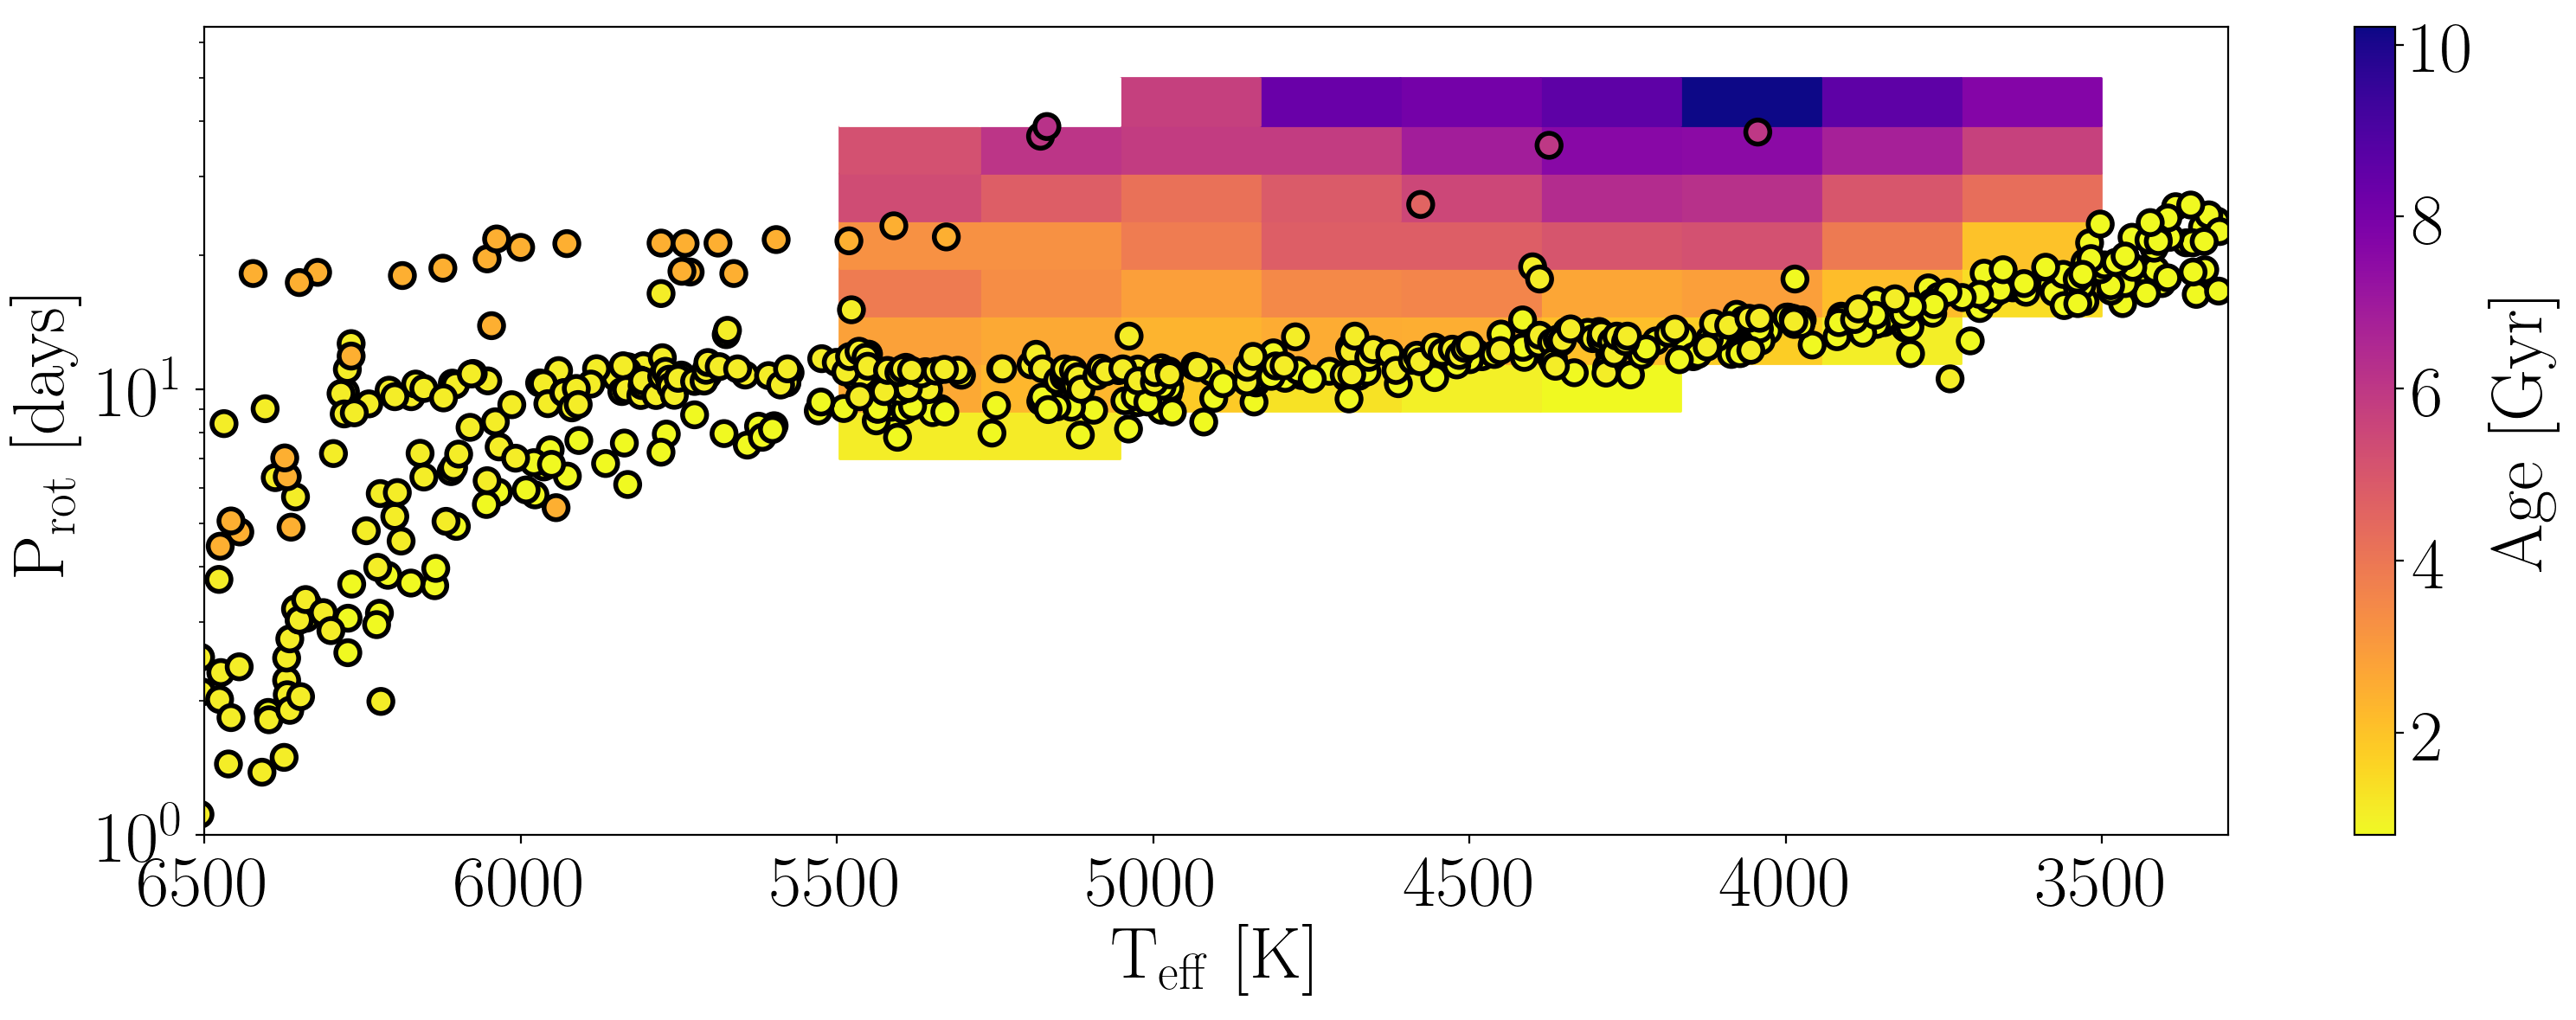

In [76]:
cmap = plt.cm.get_cmap('plasma_r')
avmin, avmax = np.min(ages[ages > 0]), np.max(ages[np.isfinite(ages)])
acolor_values = (ages - avmin)/(avmax - avmin)
argba_plasma = cmap(acolor_values)

fig = plt.figure(figsize=(16, 6), dpi=200)
ax3 = fig.add_subplot(111)

for i, m in enumerate(period_masks):    
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    
#     for j in range(len(tbins)-1):
#         tm = (x[m][clipping_mask] > tbins[j]) * (x[m][clipping_mask] < tbins[j+1])
#         cb1 = plt.scatter(x[m][clipping_mask][tm], y[m][clipping_mask][tm],
#                           c=np.ones_like(y[m][clipping_mask][tm])*ages[i, j],
#                           vmin=avmin, vmax=avmax,
#                           rasterized=True, zorder=0, s=50, cmap="plasma_r")
    for j in range(len(tbins)-1):
        tm = (x[m][clipping_mask] > tbins[j]) * (x[m][clipping_mask] < tbins[j+1])
#         cb1 = plt.scatter(x[m][clipping_mask][tm], y[m][clipping_mask][tm],
#                           c=np.ones_like(y[m][clipping_mask][tm])*ages[i, j],
#                           vmin=avmin, vmax=avmax, rasterized=True, zorder=2, s=.01, cmap="plasma_r")
        xs = np.linspace(tbins[j], tbins[j+1], 10)
        color = argba_plasma[i, j]
        if not np.isfinite(ages[i, j]):
            color = "w"
        ax3.fill_between(xs, np.ones_like(xs)*period_bins[i], np.ones_like(xs)*period_bins[i+1],
                         color=color, zorder=1)

plt.scatter(cl.teff, cl.period, c=cl.age_gyr,
            edgecolor="k", vmin=avmin, vmax=avmax, s=100, cmap="plasma_r", lw=2)
plt.scatter(df.teff, df.prot, c=np.ones_like(df.teff)*1.1,
            edgecolor="k", vmin=avmin, vmax=avmax, s=100, cmap="plasma_r", lw=2)
plt.scatter(fi.teff, fi.prot, c=fi.age,
            edgecolor="k", vmin=avmin, vmax=avmax, s=100, cmap="plasma_r", lw=2)
        
plt.colorbar(cb1, label="$\mathrm{Age~[Gyr]}$")
ax3.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax3.set_xlim(6500, xlim[1])
ax3.set_yscale("log")
ax3.set_ylim(1, 65)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.tight_layout()

(8, 9) (8,) (9,)


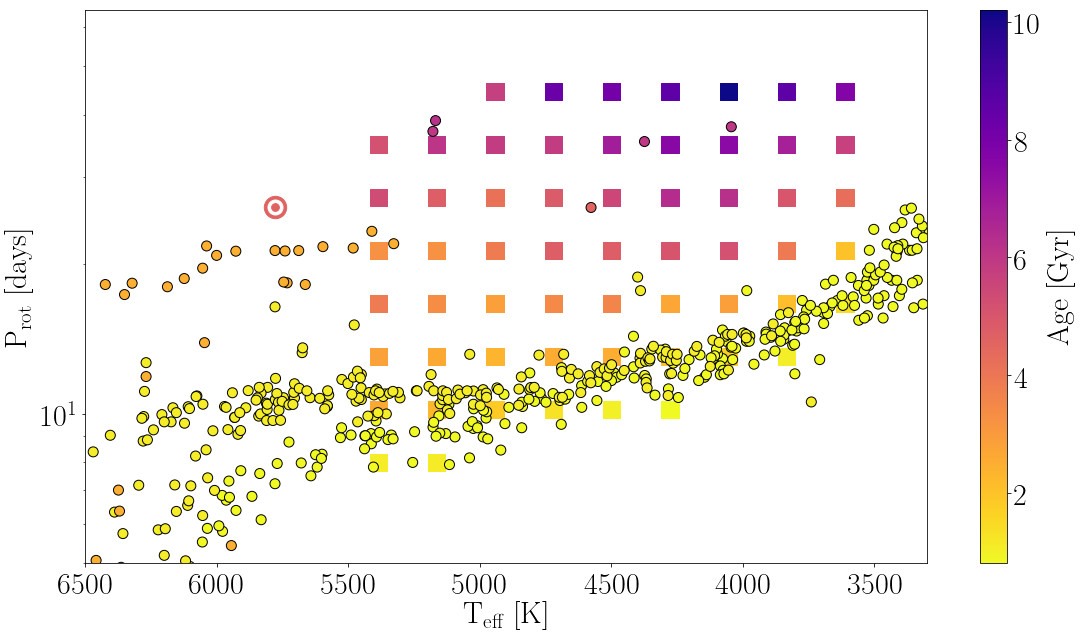

In [132]:
plt.figure(figsize=(16, 9))
for i in range(len(mid_period_bins)):
    plt.scatter(mid_teff_bins, np.ones_like(mid_teff_bins)*mid_period_bins[i], c=ages[i, :],
               cmap="plasma_r", marker="s", vmin=avmin, vmax=avmax, s=300)

plt.scatter(cl.teff, cl.period, c=cl.age_gyr,
            edgecolor="k", vmin=avmin, vmax=avmax, s=100, cmap="plasma_r", lw=1)
plt.scatter(df.teff, df.prot, c=np.ones_like(df.teff)*1.1,
            edgecolor="k", vmin=avmin, vmax=avmax, s=100, cmap="plasma_r", lw=1)
plt.scatter(fi.teff, fi.prot, c=fi.age,
            edgecolor="k", vmin=avmin, vmax=avmax, s=100, cmap="plasma_r", lw=1)
        
plt.scatter([5778], [26], c=[4.6], s=500, vmin=avmin, vmax=avmax, cmap="plasma_r", zorder=0)
plt.plot(5778, 26, "wo", ms=15, zorder=1)
plt.scatter([5778], [26], c=[4.6], s=60, vmin=avmin, vmax=avmax, cmap="plasma_r", zorder=2)

plt.colorbar(label="$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.xlim(6500, xlim[1])
plt.yscale("log")
plt.ylim(5, 65)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.tight_layout()
plt.savefig("calibration_data")
plt.savefig("calibration_data.pdf")

In [162]:
df["age"] = np.ones_like(df.teff)*1.1
fi["age_gyr"] = fi.age
fi["period"] = fi.prot

ps, ts, a_s = [], [], []
for i in range(len(mid_period_bins)):
    ts.append(mid_teff_bins)
    ps.append(np.ones_like(mid_teff_bins)*mid_period_bins[i])
    a_s.append(ages[i, :])
ts = np.array([i for j in ts for i in j])
ps = np.array([i for j in ps for i in j])
a_s = np.array([i for j in a_s for i in j])

In [163]:
cal_data = pd.DataFrame(dict({"teff": ts, "period": ps, "age_gyr": a_s}))

sun = pd.DataFrame(dict({"teff": [5778], "period": [26], "age_gyr": [4.6]}))

In [164]:
data = pd.concat([df, fi, cl, cal_data, sun])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


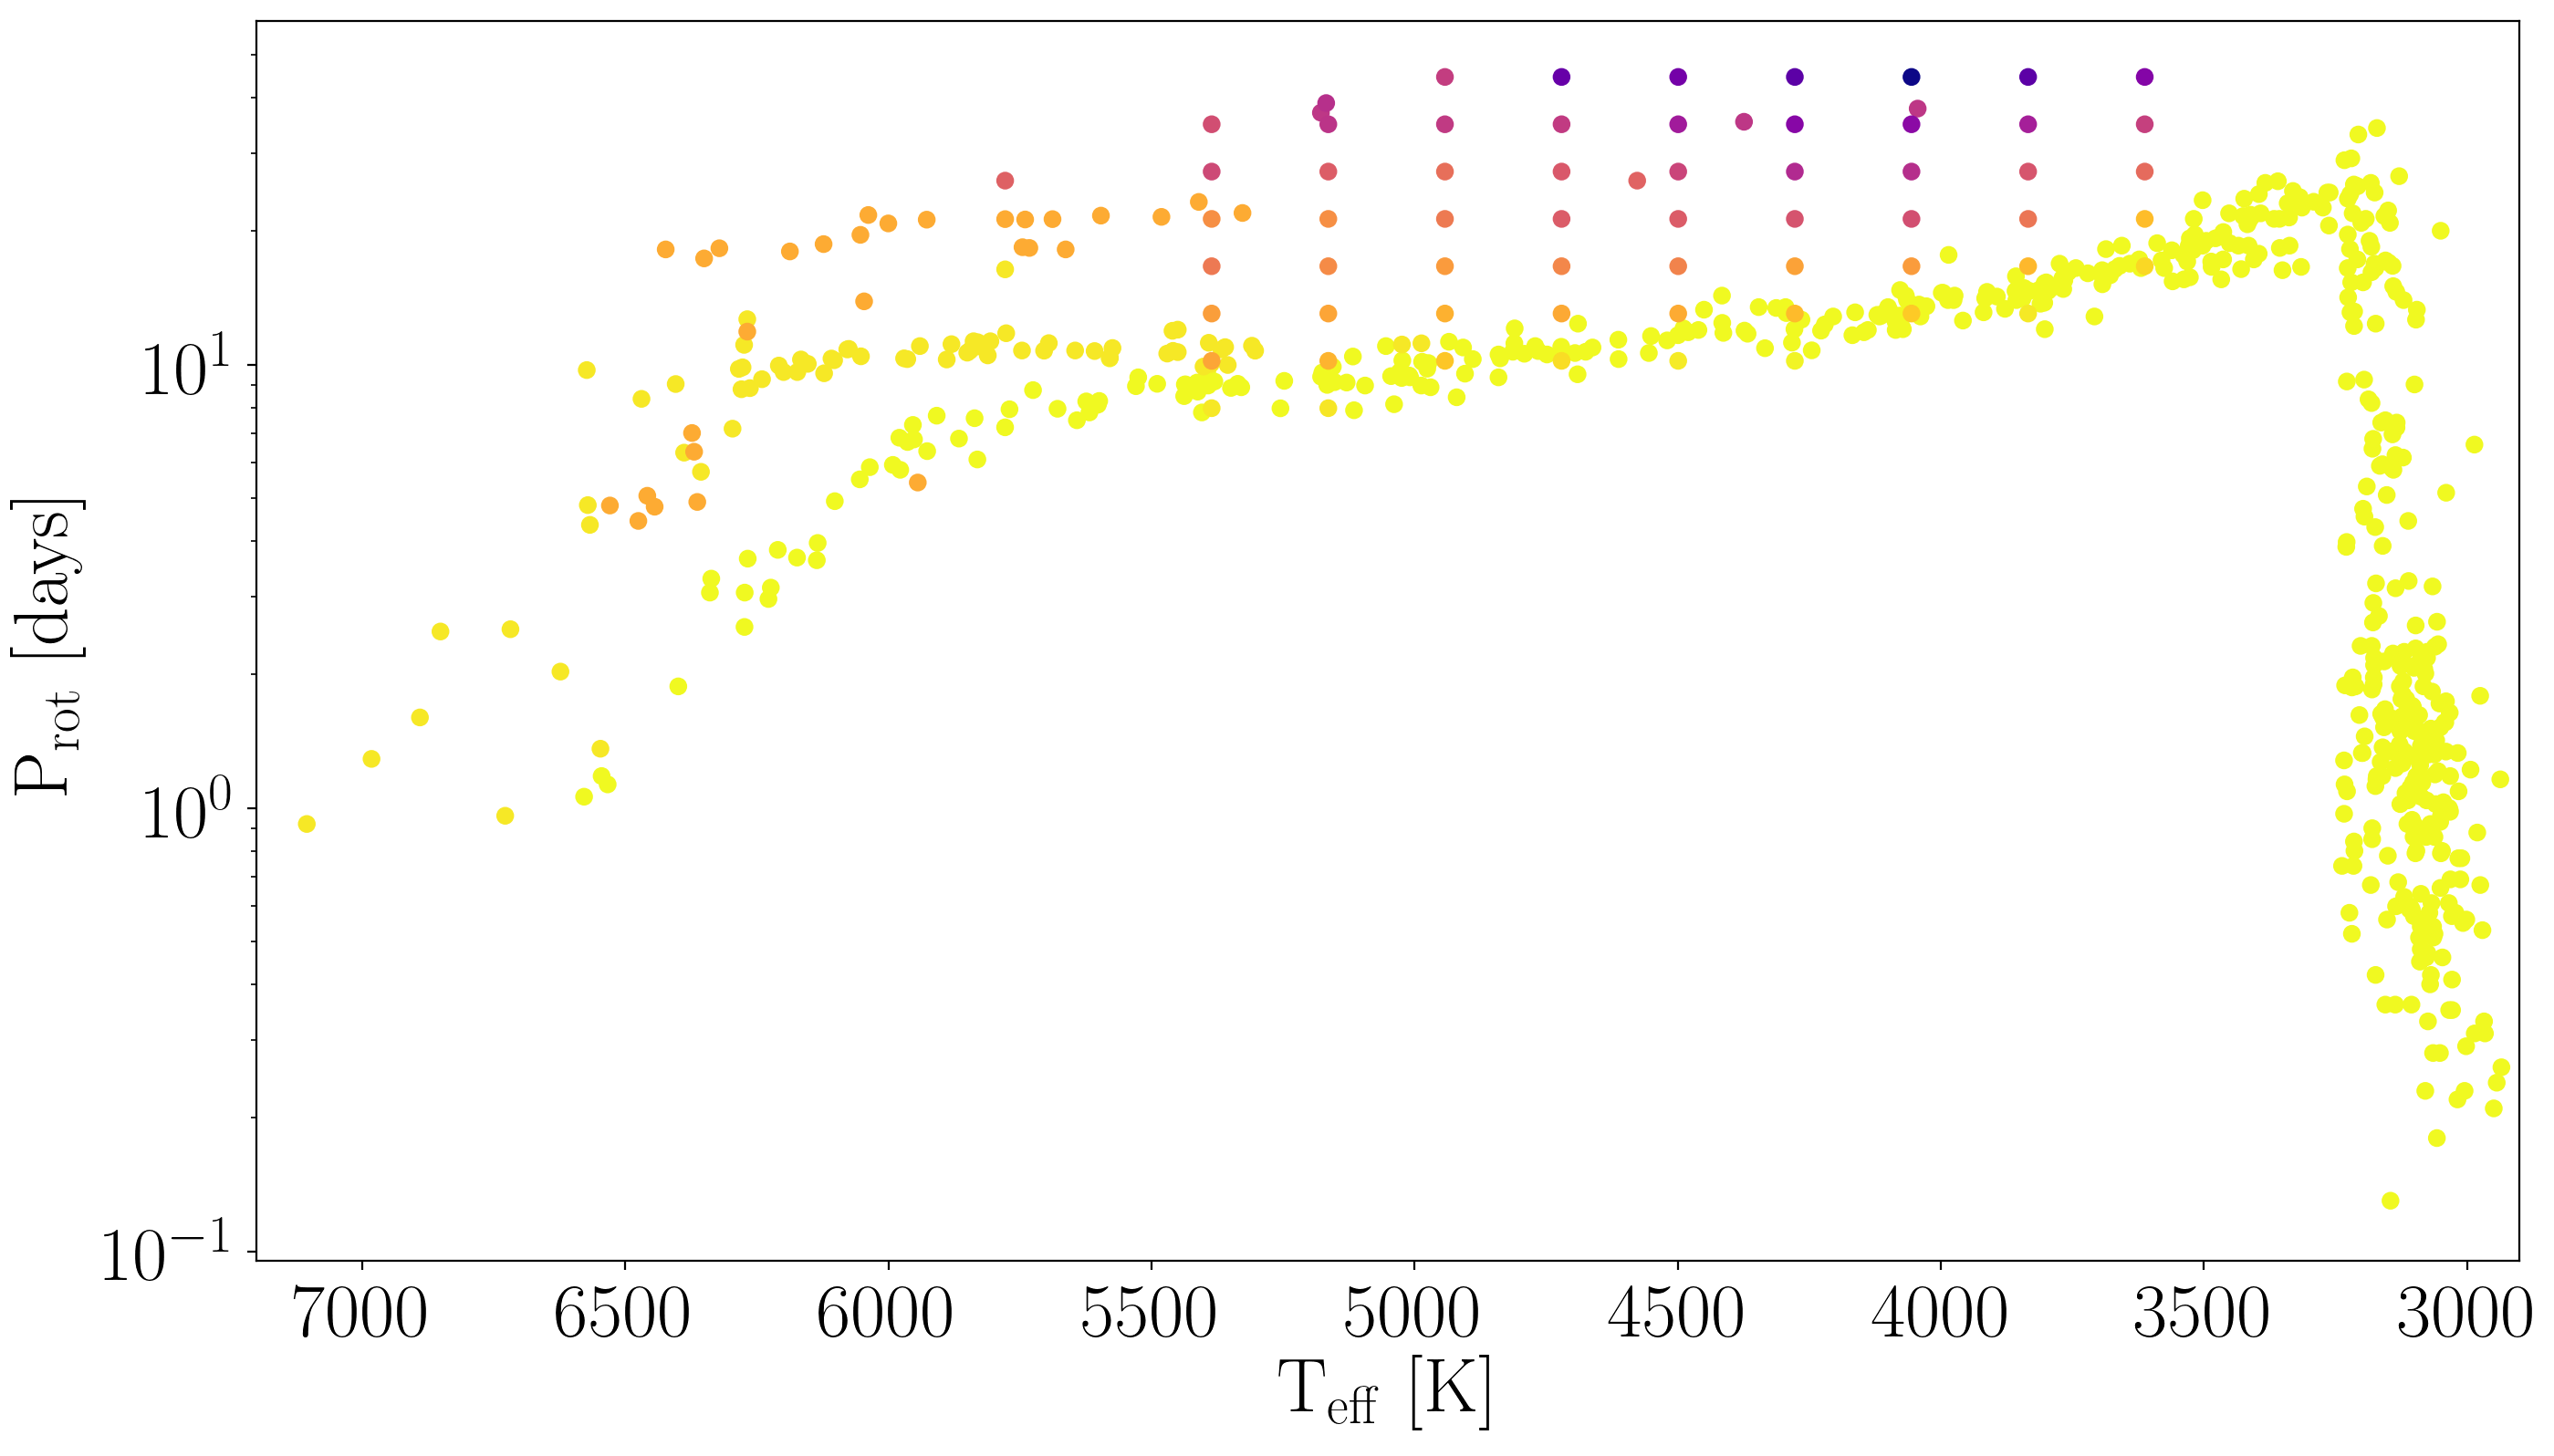

In [171]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(data.teff, data.period, c=data.age_gyr, cmap="plasma_r")
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.xlim(7200, 2900)
plt.yscale("log")

In [172]:
data.to_csv("calibration_data.csv")